In [1]:
import torch
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/avic/OOD_Orientation_Generalization')
from my_dataclasses import *
from train.dataset import *
from train.train import *
from tools import get_all_generated_canonical_heatmaps, get_heatmap_cell_ranges2
import seaborn as sns
from pandas.api.types import CategoricalDtype
import itertools
import functools
from sklearn.preprocessing import normalize
from matplotlib_venn import *
from sklearn.preprocessing import minmax_scale

In [2]:
def get_unrestricted_axis(restricted_axes):
    if restricted_axes[1] == '1':
        return 0
    if restricted_axes[4] == '1':
        return 2
    return 1

BASE_PATH = '/home/avic/OOD_Orientation_Generalization'

def get_exps_frame(exp_iter):
    exps_frame = pd.read_csv(os.path.join(BASE_PATH, f'exps{exp_iter}.csv'), index_col=[5,2])
    exps_frame = exps_frame[exps_frame.model_type == 'ModelType.ResNet']
    exps_frame = exps_frame[exps_frame.hole != 2]
    exps_frame = exps_frame[~exps_frame.pretrained & ~exps_frame.scale]
    exps_frame = exps_frame[~(exps_frame.training_category == 'lamp')]
    exps_frame['run'] = exp_iter
    exps_frame['pred_model_i'] = exps_frame.restriction_axes.apply(get_unrestricted_axis) + exps_frame.hole
    
    fits = pd.read_csv(os.path.join(BASE_PATH, f'fits/exp{exp_iter}_fits.csv')).reset_index()
    
    joined_subset = exps_frame.merge(fits, on=['num', 'data_div', 'unrestricted_axis'])
    return joined_subset

In [3]:
exps_frames = pd.concat([get_exps_frame(exp_iter) for exp_iter in range(1, 4)]).reset_index()

In [4]:
models = get_all_generated_canonical_heatmaps()[:4]

In [5]:
def sig(arr, x, y, z):
    return np.divide(1, 1 + np.exp(((-np.power(arr, x)) + y) * z))

def fitted_model(exp):
    
    exp_model = models[exp.pred_model_i]
    
    CA0, CA1, CA2, CE0, CE1, CE2, CAf0, CAf1, CAf2, CEf0, CEf1, CEf2 = exp[44:-1]
    
    component_args = [
        [CA0, CA1, CA2],
        [CE0, CE1, CE2],
        [CAf0, CAf1, CAf2],
        [CEf0, CEf1, CEf2]
    ]
    
    return np.sum(np.stack([sig(exp_model[x], *component_args[x]) for x in range(4)]), axis=0)

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [ ]:
# exp = exps_frames[exps_frames.job_id == 31].iloc[0]#exps_frames.iloc[15]

# heatmap = np.load(exp.eval_heatmap)
# fitted = fitted_model(pred_models[exp.pred_model_i], exp)

plt.close('all')

THRESH = 0.1

exps = exps_frames[:12][exps_frames.data_div == 40]
_, axes = plt.subplots(12, 20, figsize=(40, 15))
for x in range(3):
    exp = exps.iloc[x]
    h = np.nan_to_num(np.load(exp.eval_heatmap))

    m = fitted_model(exp)
    
    ha = h.copy()
    mask = (NormalizeData(m) > THRESH)
    ha[mask] = 0
    
    for y in range(20):
        
        a = [2, 0, 1][x]
        if a == 0:
            s = np.s_[y]
        if a == 1:
            s = np.s_[:, y]
        else:
            s = np.s_[..., y]

        axes[(x * 4), y].imshow(h[s], norm=plt.Normalize(vmin=0, vmax=1))
        axes[(x * 4) + 1, y].imshow(m[s], norm=plt.Normalize(vmin=0, vmax=1))
        axes[(x * 4) + 2, y].imshow(mask[s], norm=plt.Normalize(vmin=0, vmax=1))
        axes[(x * 4) + 3, y].imshow(ha[s], norm=plt.Normalize(vmin=0, vmax=1))

In [ ]:
# from sklearn.cluster import KMeans, DBSCAN
# from sklearn import metrics

def l1_norm(arr):
    return (arr - arr.mean()) / arr.std()
    return arr / np.linalg.norm(arr, 1)

def my_pierson(x, y):
    x_avg = np.expand_dims(np.mean(x, axis=-1), axis=-1)
    y_avg = np.expand_dims(np.mean(y, axis=-1), axis=-1)
    x_std = np.std(x, axis=-1)
    y_std = np.std(y, axis=-1)

    return (((x - x_avg) @ (y - y_avg)) / ((x_std * y_std) * (x.shape[-1])))

In [6]:
bin_ranges = np.array(
    [[[-5, 5],
      [-0.25, 0.25],
      [-0.25, 0.25]],
     [[-0.25, 0.25],
      [-5, 5],
      [-0.25, 0.25]],
     [[-0.25, 0.25],
      [-0.25, 0.25],
      [-5, 5]]])

def threshold_model(exp):
    threshs = np.linspace(0, 10, 1000)
    exp_heatmap = np.load(exp.eval_heatmap)
    exp_fitted_model = fitted_model(exp)
    thresh = threshs[np.argmin(np.mean((np.expand_dims(exp_fitted_model, -1) > np.expand_dims(threshs, (0, 1, 2))) ^ np.expand_dims((exp_heatmap > 0.2), -1), axis=(0, 1, 2)))]
    return exp_fitted_model > thresh

def classify_image_patterns(exp, df, thesholded_model):
    xs, ys, zs = get_heatmap_cell_ranges2(20)
    cubelet_ranges = np.array(list(itertools.product(*[np.stack([vs[:-1], vs[1:]]).T for vs in [xs, ys, zs]]))).reshape(20, 20, 20, 3, 2)
    
    bin_range = bin_ranges[exp.pred_model_i]
    
    df['in_bin'] = df.object_x.between(*bin_range[0]) & df.object_y.between(*bin_range[1]) & df.object_z.between(*bin_range[2])
    df['outside_model'] = ~df.in_bin & functools.reduce(lambda a, b: a | (df.object_x.between(*b[0]) & df.object_y.between(*b[1]) & df.object_z.between(*b[2])), cubelet_ranges[~thesholded_model], False)
    df['in_model'] = ~df.in_bin & ~df.outside_model
    
    df['pattern'] = (df.in_bin + (df.outside_model * 2) + (df.in_model * 3)).apply(lambda x: ['none', 'bin', 'outside_model', 'in_model'][x])

In [8]:
def a(group):

    bin_activation = np.nanmean(norm_image_activations[df[(df.model_name == group.model_name.iloc[0]) & df.in_bin].index], axis=0)
    group_image_activations = norm_image_activations[group.index]
    
    image_invariances = 1 - np.abs((group_image_activations - bin_activation) / (group_image_activations + bin_activation))

    image_invariances_thresholded = np.where((group_image_activations > 0.2) | (bin_activation > 0.2), image_invariances, np.nan)

    return image_invariances_thresholded

In [13]:
violin_data = None
corr_data = None

thresholded_model = threshold_model(exps_frames.iloc[3])

for x in range(4):
    exp = exps_frames.iloc[x]
    exp_dataclass = ExpData.get_experiments(exp.job_id)

    image_activations = np.load(exp_dataclass.image_activations)

    rd = RotationDataset(exp_dataclass)
    df = pd.read_csv(rd.testing.full.path.merged_annotation_path())

    classify_image_patterns(exp, df, thresholded_model)

    df['seen'] = df.model_name.isin(rd.training_models).apply(lambda s: ['partial', 'full'][s])

    norm_image_activations = image_activations / np.max(image_activations, axis=0)
    
    invariances = df.groupby(['model_name', 'seen', 'pattern']).apply(a).reset_index()
    data = invariances.groupby(['model_name', 'pattern'])[0].apply(lambda arr: np.nanmean(np.concatenate(arr.values), axis=0)).reset_index()
    data['seen'] = data.model_name.isin(rd.training_models).apply(lambda s: ['partial', 'full'][s])
    data = data.rename({0: 'invariance'}, axis=1)
    data = data.explode('invariance')
    data.invariance = data.invariance.astype(float)

    data['#seen'] = exp.data_div
    if violin_data is None:
        violin_data = data
    else:
        violin_data = violin_data.append(data)


    print(f'done {x}')

/home/avic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/avic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


done 0
done 1
done 2
done 3


In [14]:
plt.style.use('default')

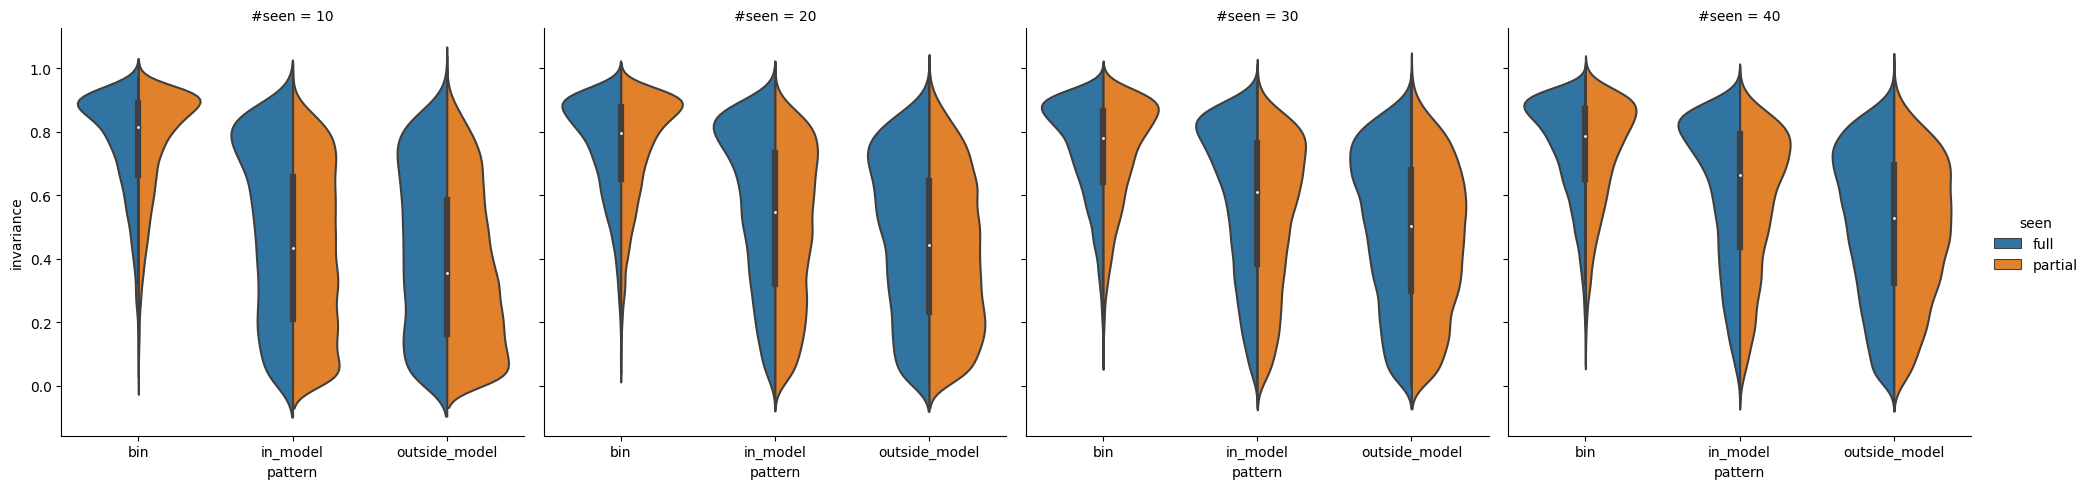

In [15]:
sns.catplot(kind='violin', data=violin_data, col='#seen', x='pattern', y='invariance', split=True, hue='seen', hue_order=['full', 'partial'])

In [ ]:
invariance_diff = violin_data.groupby(['pattern', '#seen']).apply(lambda group: group[group.seen == 'full'].invariance.to_numpy() - group[group.seen == 'partial'].invariance.to_numpy()).reset_index()
invariance_diff.rename({0: 'invariance'}, axis=1, inplace=True)
invariance_diff = invariance_diff.explode('invariance')

In [ ]:
sns.catplot(kind='violin', data=violin_data, col='#seen', x='pattern', y='invariance', split=True)

In [7]:
violin_data = None
corr_data = None

thresholded_model = threshold_model(exps_frames.iloc[3])

exp = exps_frames.iloc[3]
exp_dataclass = ExpData.get_experiments(exp.job_id)

# image_activations = np.load(exp_dataclass.image_activations)

rd = RotationDataset(exp_dataclass)
df = pd.read_csv(rd.testing.full.path.merged_annotation_path())
classify_image_patterns(exp, df, thresholded_model)


df['seen'] = df.model_name.isin(rd.training_models).apply(lambda s: ['partial', 'full'][s])

# classify_image_patterns(exp, df, thresholded_model)

# df['seen'] = df.model_name.isin(rd.training_models).apply(lambda s: ['partial', 'full'][s])

# norm_image_activations = image_activations / np.max(image_activations, axis=0)

In [8]:
image_activations = np.load(exp_dataclass.image_activations)
norm_image_activations = image_activations / np.max(image_activations, axis=0)

In [9]:
fully_seen_model_activations = df[df.seen == 'full'].groupby(['model_name', 'pattern']).apply(lambda group: np.nanmean(norm_image_activations[group.index], axis=0)).reset_index().rename({0: 'invariance'}, axis=1)

In [7]:
def c(pre_act, post_act):
    image_invariances = 1 - np.abs((post_act - pre_act) / (post_act + pre_act))

    return np.nanmean(np.where((post_act > 0.2) | (pre_act > 0.2), image_invariances, np.nan), axis=0)

In [8]:
thresholded_model = threshold_model(exps_frames.iloc[3])

In [9]:
violin_data = None
corr_data = None

thresholded_model = threshold_model(exps_frames.iloc[3])

for x in range(4):
    exp = exps_frames.iloc[x]
    exp_dataclass = ExpData.get_experiments(exp.job_id)

    image_activations = np.load(exp_dataclass.image_activations)

    rd = RotationDataset(exp_dataclass)
    df = pd.read_csv(rd.testing.full.path.merged_annotation_path())

    classify_image_patterns(exp, df, thresholded_model)

    df['seen'] = df.model_name.isin(rd.training_models).apply(lambda s: ['partial', 'full'][s])

    norm_image_activations = image_activations / np.max(image_activations, axis=0)
    
    
    fully_seen_model_activations = df[df.seen == 'full'].groupby(['model_name', 'pattern']).apply(lambda group: np.nanmean(norm_image_activations[group.index], axis=0)).reset_index().rename({0: 'invariance'}, axis=1)
    
    def b(group):

        group_image_activations = norm_image_activations[group.index]

        image_invariances = np.stack(fully_seen_model_activations[fully_seen_model_activations.pattern == group.name[2]].invariance.apply(lambda inv: c(inv, group_image_activations)).values)

        max_model_invariance = np.nanmean(image_invariances, axis=0)

        return max_model_invariance

    invariances = df.groupby(['model_name', 'seen', 'pattern']).apply(b).reset_index()
    data = invariances.groupby(['model_name', 'pattern'])[0].apply(lambda arr: np.nanmean(np.concatenate(arr.values), axis=0)).reset_index()
    data['seen'] = data.model_name.isin(rd.training_models).apply(lambda s: ['partial', 'full'][s])
    data = data.rename({0: 'invariance'}, axis=1)
    data = data.explode('invariance')
    data.invariance = data.invariance.astype(float)

    data['#seen'] = exp.data_div
    if violin_data is None:
        violin_data = data
    else:
        violin_data = violin_data.append(data)


    print(f'done {x}')

/home/avic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/home/avic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice


done 0
done 1
done 2
done 3


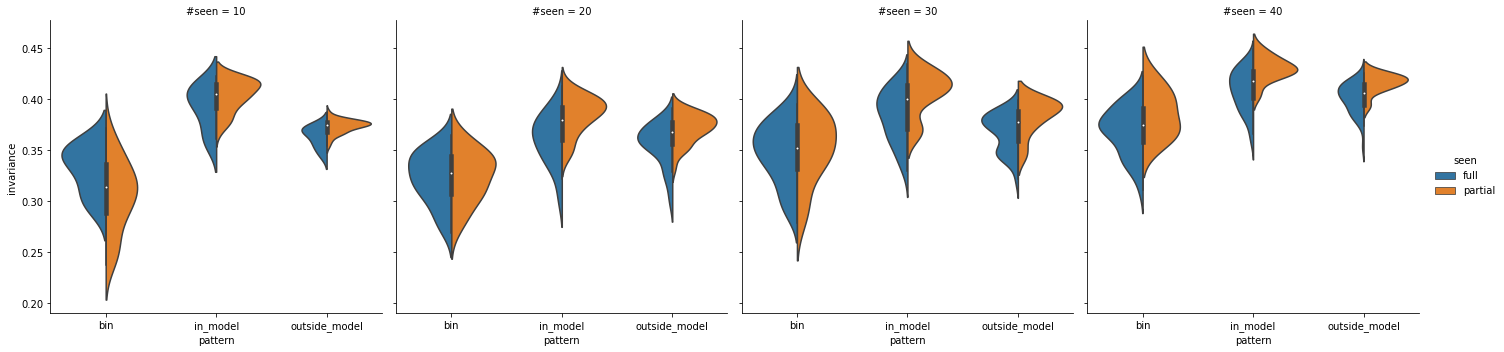

In [12]:
sns.catplot(kind='violin', data=violin_data, col='#seen', x='pattern', y='invariance', split=True, hue='seen', hue_order=['full', 'partial'])

In [7]:
thresholded_model = threshold_model(exps_frames.iloc[3])

exp = exps_frames.iloc[3]
exp_dataclass = ExpData.get_experiments(exp.job_id)

image_activations = minmax_scale(np.load(exp_dataclass.image_activations))

rd = RotationDataset(exp_dataclass)
df = pd.read_csv(rd.testing.full.path.merged_annotation_path())

classify_image_patterns(exp, df, thresholded_model)

df['seen'] = df.model_name.isin(rd.training_models).apply(lambda s: ['partial', 'full'][s])

df.model_name = df.model_name.astype('category')

In [8]:
training_idxs = np.sort(df[df.model_name.isin(rd.training_models)].model_name.cat.codes.unique())
testing_idxs = np.sort(df[df.model_name.isin(rd.testing_models)].model_name.cat.codes.unique())

In [9]:
xs, ys, zs = get_heatmap_cell_ranges2(20)
cubelet_ranges = np.array(list(itertools.product(*[np.stack([vs[:-1], vs[1:]]).T for vs in [xs, ys, zs]]))).reshape(20, 20, 20, 3, 2)

df['cubelet_i'] = functools.reduce(lambda acc, item: acc + ((df.object_x.between(*item[1][0], 'left') & df.object_y.between(*item[1][1], 'left') & df.object_z.between(*item[1][2], 'left')) * item[0]), tqdm(enumerate(cubelet_ranges.reshape(8000, 3, 2)), total=8000), np.zeros(250_000)).astype(int)

100%|██████████| 8000/8000 [00:28<00:00, 277.38it/s]


In [10]:
neuron_heatmaps = np.zeros((512, 50, 8000))
groups = df.groupby(['model_name', 'cubelet_i'])
for name, group in tqdm(groups, total=len(groups)):
    neuron_heatmaps[:, group.model_name.cat.codes.iloc[0], name[1]] = image_activations[group.index].mean(axis=0)

100%|██████████| 185705/185705 [01:13<00:00, 2514.58it/s]


In [11]:
training_neuron_heatmaps = neuron_heatmaps[:,training_idxs]
testing_neuron_heatmaps = neuron_heatmaps[:,testing_idxs]

In [12]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

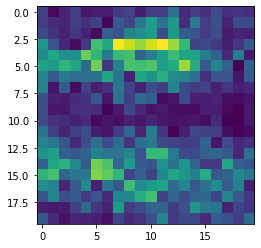

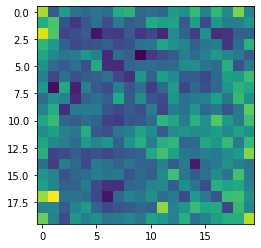

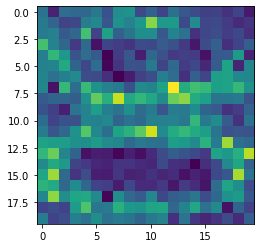

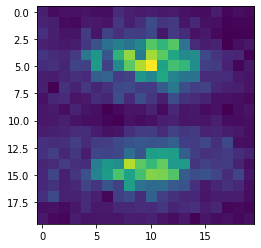

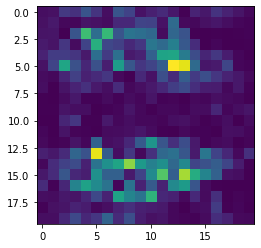

In [14]:
for x in range(5):
    plt.imshow(training_neuron_heatmaps[x, 0].reshape(20, 20, 20).mean(axis=2))
    plt.show()

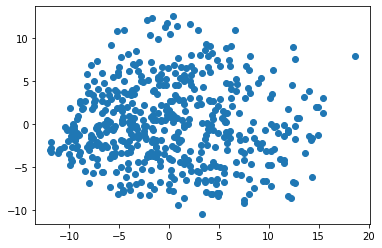

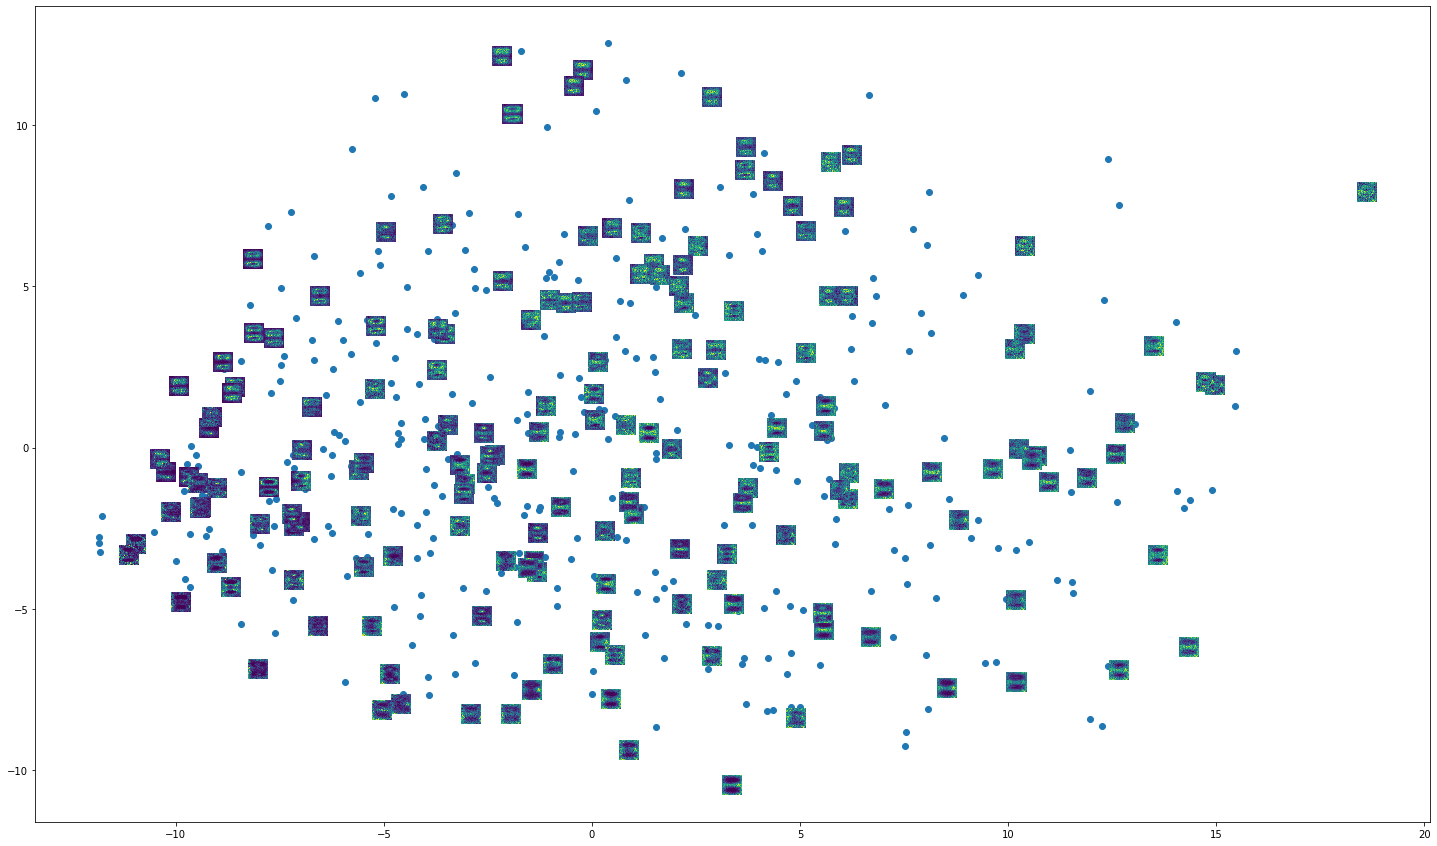

In [15]:
pca = PCA(2)
projected = pca.fit_transform(minmax_scale(testing_neuron_heatmaps[:,1], axis=1))

plt.close('all')
plt.scatter(projected[:, 0], projected[:, 1])
fig, ax = plt.subplots(figsize=(25, 15))
ax.scatter(projected[:, 0], projected[:, 1]) 

for i in range(0, 512, 3):
    arr = testing_neuron_heatmaps[i,1].reshape(20, 20, 20).mean(axis=2)
    im = OffsetImage(arr, zoom=1)
    im.image.axes = ax

    ab = AnnotationBbox(im, projected[i],
                    frameon=False)
    
    ax.add_artist(ab)
    
plt.savefig('./scatter_with_neurons_pca.png', dpi=500)

In [16]:
from sklearn.cluster import KMeans

In [ ]:
n_clusters = 5
# pca = PCA(2)
tsne = TSNE(2)
projected = tsne.fit_transform(minmax_scale(training_neuron_heatmaps[:,0], axis=1))
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(projected)

plt.close('all')
plt.scatter(projected[:, 0], projected[:, 1], c=kmeans.labels_)
plt.show()
plt.bar(range(n_clusters), [np.sum(kmeans.labels_ == x) for x in range(n_clusters)])
plt.show()
_, axes = plt.subplots(1, n_clusters, figsize=(20, 10))
for x in range(n_clusters):
    axes[x].imshow(training_neuron_heatmaps[:, 0][np.argmin(np.sqrt(np.sum(np.power(projected - kmeans.cluster_centers_[x], 2), axis=1)))].reshape(20, 20, 20).mean(axis=2))#, vmin=0, vmax=1)
    axes[x].set_xticks([])
    axes[x].set_yticks([])
plt.tight_layout()

In [95]:
testing_neuron_heatmaps[0].T.shape

(8000, 10)

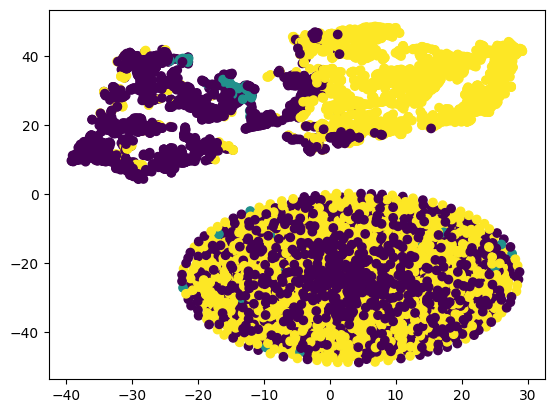

In [98]:
tsne = TSNE(2)
projected = tsne.fit_transform(minmax_scale(testing_neuron_heatmaps[:, 0].T, axis=1))

plt.close('all')
plt.scatter(projected[:, 0], projected[:, 1], c=cubelet_classes)
# fig, ax = plt.subplots(figsize=(25, 15))
# ax.scatter(projected[:, 0], projected[:, 1]) 

# for i in range(0, 512, 3):
#     arr = testing_neuron_heatmaps[i,1].reshape(20, 20, 20).mean(axis=2)
#     im = OffsetImage(arr, zoom=1)
#     im.image.axes = ax

#     ab = AnnotationBbox(im, projected[i],
#                     frameon=False)
    
#     ax.add_artist(ab)
    
# plt.savefig('./scatter_with_neurons_pca.png', dpi=500)

In [91]:
cubelet_classes = np.zeros((20, 20, 20))
cubelet_classes[((cubelet_ranges[..., 0, 0] > -0.25) & (cubelet_ranges[..., 0, 0] < 0.25) & \
           ((cubelet_ranges[..., 1, 0] > -0.25) & (cubelet_ranges[..., 1, 0] < 0.25)))] = 1
cubelet_classes[~thresholded_model & ~cubelet_classes.astype(bool)] = 2

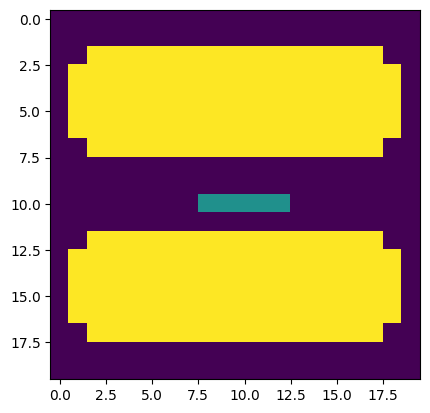

In [92]:
plt.imshow(cubelet_classes.mean(axis=2))

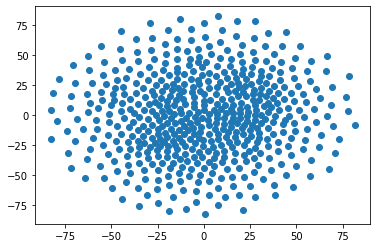

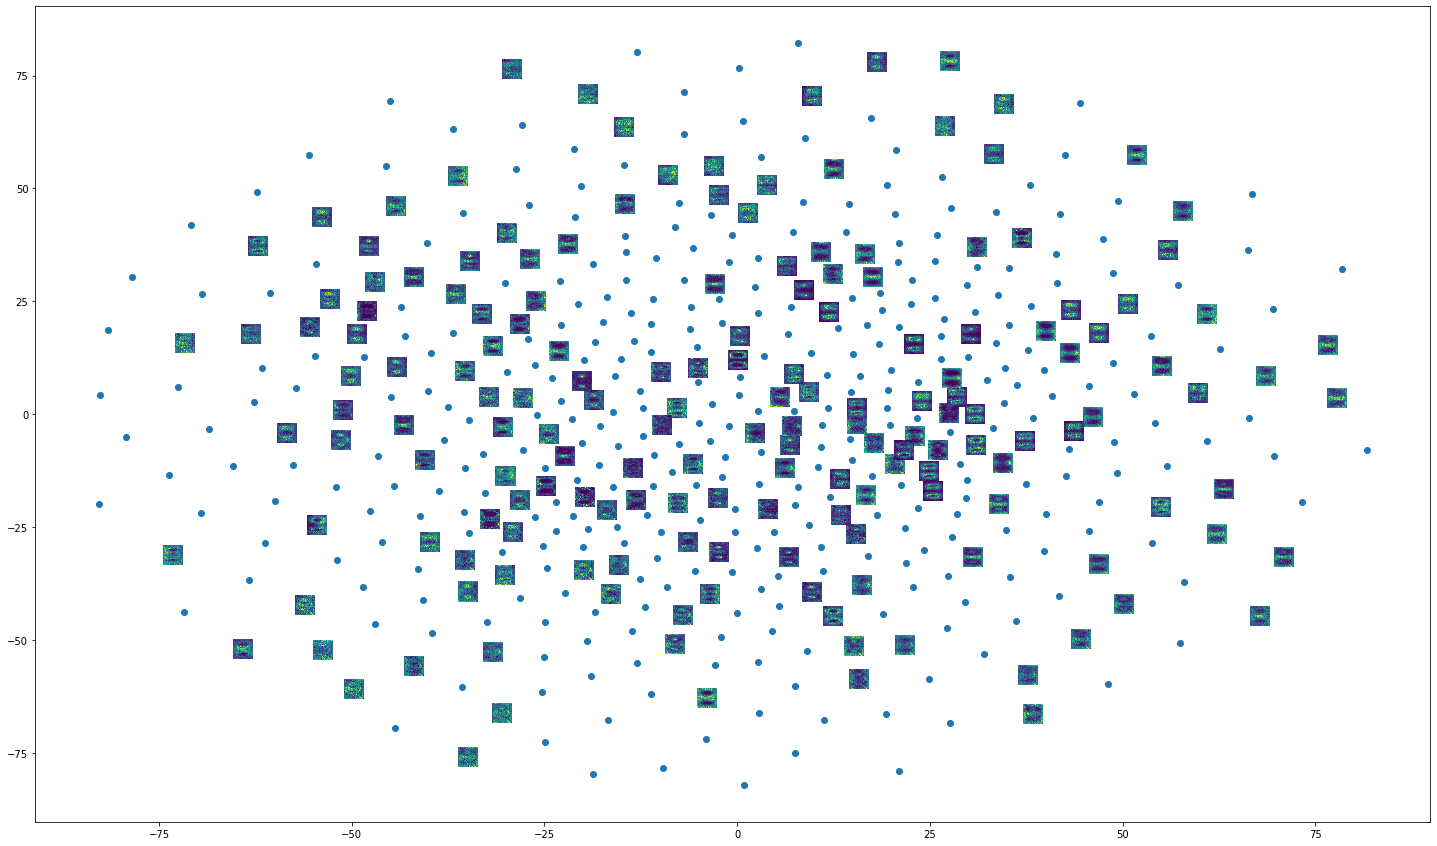

In [19]:
tsne = TSNE(2, metric='precomputed')
projected = tsne.fit_transform(np.abs(np.corrcoef(minmax_scale(testing_neuron_heatmaps[:,1], axis=1))))

plt.close('all')
plt.scatter(projected[:, 0], projected[:, 1])
fig, ax = plt.subplots(figsize=(25, 15))
ax.scatter(projected[:, 0], projected[:, 1]) 

for i in range(0, 512, 3):
    arr = testing_neuron_heatmaps[i,1].reshape(20, 20, 20).mean(axis=2)
    im = OffsetImage(arr, zoom=1)
    im.image.axes = ax

    ab = AnnotationBbox(im, projected[i],
                    frameon=False)
    
    ax.add_artist(ab)
    
plt.savefig('./scatter_with_neurons_pca.png', dpi=500)

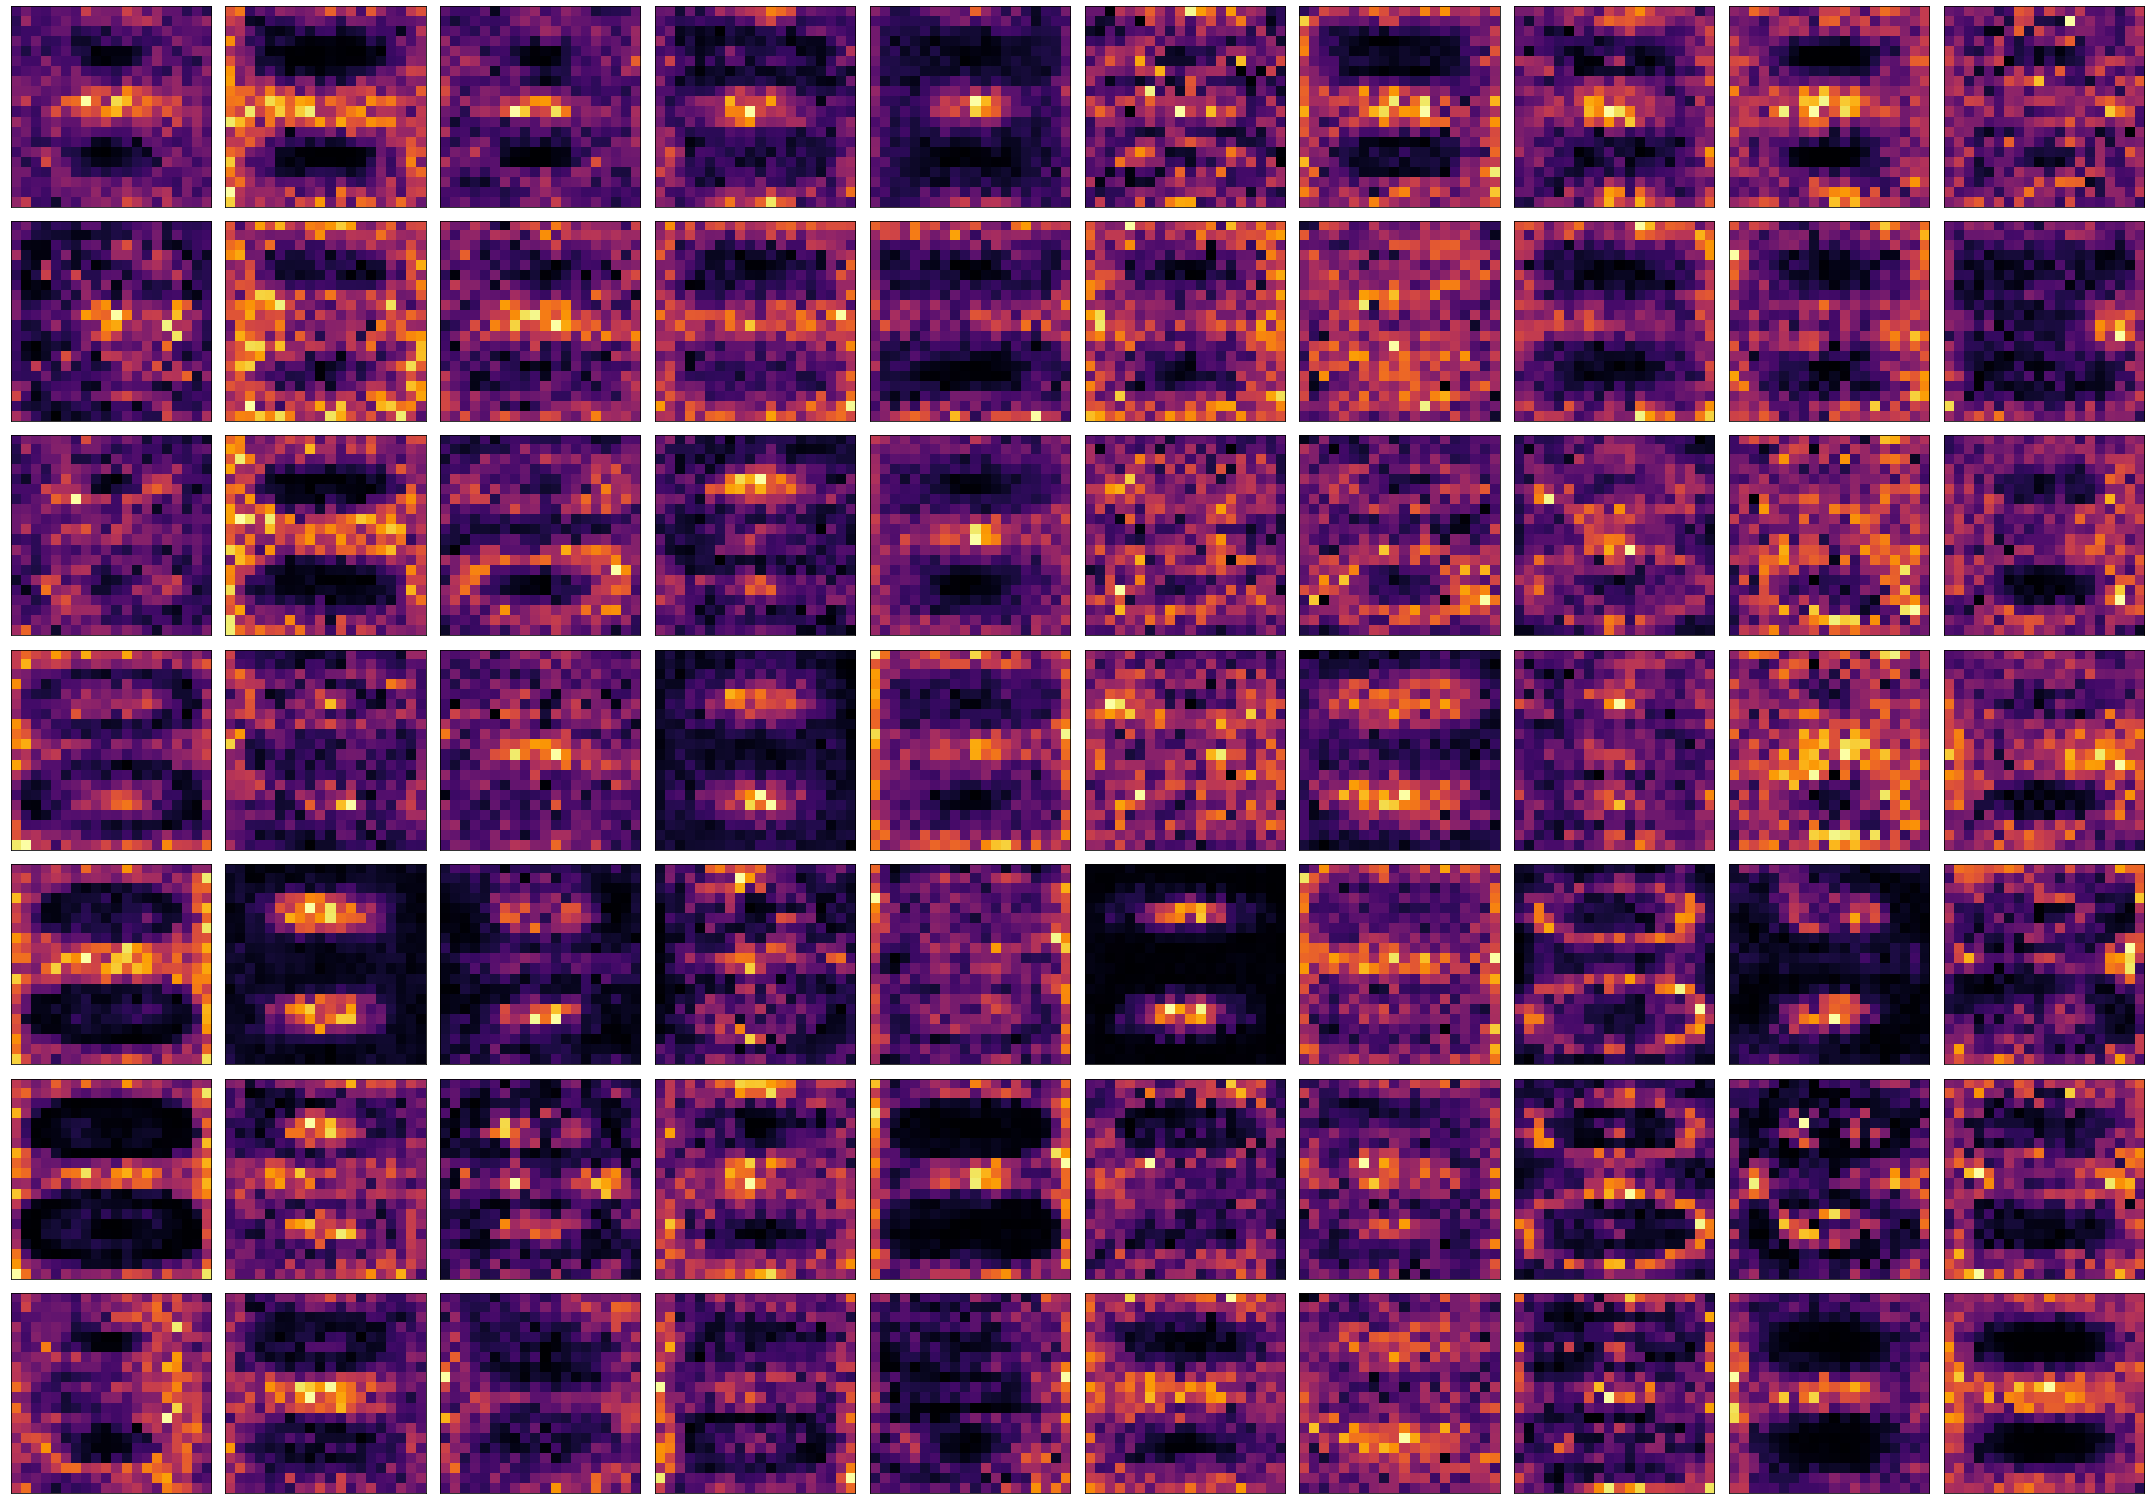

In [20]:
plt.close('all')
fig, axes = plt.subplots(7, 10, figsize=(30, 21))
for x in range(7):
    for y in range(10):
        axes[x, y].imshow(testing_neuron_heatmaps[x, y].reshape(20, 20, 20).mean(axis=2), cmap='inferno')
        axes[x, y].set_xticks([])
        axes[x, y].set_yticks([])
plt.tight_layout()

In [ ]:
plt.colorbar()

In [ ]:
from skimage.metrics import structural_similarity as ssim
from cv2 import bilateralFilter

def euc_dist(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

def custom_pierson(x, y):
    
    y[(x < 0.1) & (y > 0.1)] *= 10
    x[(y < 0.1) & (x > 0.1)] *= 10
    # return x, y
    
    x_mean = np.mean(x, axis=-1)
    y_mean = np.mean(y, axis=-1)
    x_std = np.std(x, axis=-1)
    y_std = np.std(y, axis=-1)

    return (((x - x_mean) @ (y - y_mean)) / ((x_std * y_std) * (x.shape[-1])))

In [ ]:
original = training_neuron_heatmaps[0, 2].reshape(20, 20, 20)
modified_fig8 = original.copy()
modified_fig8[0:2, 8:12, :] += 0.1
modified_fig8[18:20, 8:12, :] += 0.1
modified_hole = original.copy()
modified_hole[4:6, 8:12, :] += 0.1
modified_hole[14:16, 8:12, :] += 0.1

In [ ]:
plt.close('all')
_, axes = plt.subplots(2, 3, figsize=(10, 5))
for i, img in enumerate([original, modified_fig8, modified_hole]):
    axes[0, i].imshow(img.mean(axis=2), vmax=0.5)
    axes[1, i].imshow(bilateralFilter(img.mean(axis=2).astype('float32'), 5, 2, 3), vmax=0.5)
# axes[3].imshow(custom_pierson(original.flatten(), modified_hole.flatten())[0].reshape(20, 20, 20).mean(axis=2), vmax=0.5)
# axes[4].imshow(custom_pierson(original.flatten(), modified_hole.flatten())[1].reshape(20, 20, 20).mean(axis=2), vmax=0.5)

In [ ]:
euc_dist(original, original), euc_dist(original, modified_fig8), euc_dist(original, modified_hole)

In [ ]:
my_pierson(original.flatten(), original.flatten()), my_pierson(original.flatten(), modified_fig8.flatten()), my_pierson(original.flatten(), modified_hole.flatten())

In [ ]:
ssim(original.mean(axis=2), original.mean(axis=2)), ssim(original.mean(axis=2), modified_fig8.mean(axis=2)), ssim(original.mean(axis=2), modified_hole.mean(axis=2))

In [ ]:
custom_pierson(original.flatten(), original.flatten()), custom_pierson(original.flatten(), modified_fig8.flatten()), custom_pierson(original.flatten(), modified_hole.flatten())

In [ ]:
plt.imshow(training_neuron_heatmaps[0].reshape(40, 20, 20, 20).mean(axis=(0, 3)))

In [ ]:
plt.imshow((training_neuron_heatmaps[0] * minmax_scale(training_neuron_heatmaps[0].mean(axis=(1)))[:, np.newaxis]).reshape(40, 20, 20, 20).mean(axis=(0, 3)))

In [ ]:
minmax_scale(training_neuron_heatmaps[0].mean(axis=(1)))

In [ ]:
plt.close('all')
_, axes = plt.subplots(5, 8, figsize=(30, 20))
for x in range(5):
    for y in range(8):
        axes[x, y].imshow(training_neuron_heatmaps[7, (x * 8) + y].reshape(20, 20, 20).mean(axis=2), vmin=0, vmax=1)

In [ ]:
plt.close('all')
_, axes = plt.subplots(5, 8, figsize=(30, 20))
for x in range(5):
    for y in range(8):
        axes[x, y].imshow(training_neuron_heatmaps[x, y].reshape(20, 20, 20).mean(axis=2))

In [ ]:
exp_fitted_model.flatten().shape, training_neuron_heatmaps[:10, 0].shape

In [ ]:
my_pierson(training_neuron_heatmaps[0, 0], exp_fitted_model.flatten())

In [ ]:
plt.close('all')
_, axes = plt.subplots(5, 8, figsize=(30, 20))
for x in range(5):
    for y in range(8):
        neuron = (x * 8) + y
        avg_neuron = (training_neuron_heatmaps[neuron] * minmax_scale(training_neuron_heatmaps[neuron].mean(axis=(1)))[:, np.newaxis]).reshape(40, 20, 20, 20).mean(axis=0)
        axes[x, y].imshow(avg_neuron.mean(axis=2))
        axes[x, y].set_xlabel(my_pierson(exp_fitted_model.flatten(), avg_neuron.flatten()))

In [ ]:
avg_activations = np.average(training_neuron_heatmaps,
           axis=1,
           weights=np.broadcast_to(np.expand_dims(training_neuron_heatmaps.mean(axis=(2)), -1), (512, 40, 8000)))

In [ ]:
corrs = my_pierson(avg_activations,
          exp_fitted_model.flatten())
plt.violinplot(corrs)
pass

In [ ]:
corr_order = np.argsort(corrs)
plt.scatter(corrs[corr_order], avg_activations.mean(axis=1)[corr_order])

In [ ]:
training_neuron_heatmaps.mean(axis=(2)).shape

In [ ]:
reshaped_neuron_heatmaps.shape

In [ ]:
reshaped_neuron_heatmaps.reshape(-1, 20, 20, 20).mean(axis=3).flatten().shape

In [ ]:
corrs = my_pierson(reshaped_neuron_heatmaps.reshape(-1, 20, 20, 20).mean(axis=3).flatten(), exp_fitted_model.mean(axis=2).flatten())
plt.violinplot(corrs)
pass

In [ ]:
corrs.max(), corrs.min()

In [ ]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(reshaped_neuron_heatmaps)

plt.close('all')
plt.bar(range(n_clusters), [np.sum(kmeans.labels_ == x) for x in range(n_clusters)])
plt.show()
_, axes = plt.subplots(1, n_clusters, figsize=(20, 10))
for x in range(n_clusters):
    axes[x].imshow(kmeans.cluster_centers_[x].reshape(20, 20, 20).mean(axis=2))#, vmin=0, vmax=1)
    axes[x].set_xticks([])
    axes[x].set_yticks([])
plt.tight_layout()

In [ ]:
plt.close('all')
cluster = 0
plt.imshow(kmeans.cluster_centers_[cluster].reshape(20, 20, 20).mean(axis=2))
selected_heatmaps = reshaped_neuron_heatmaps[kmeans.labels_ == cluster][:10]
_, axes = plt.subplots(2, n_clusters, figsize=(30, 10))
for x in range(n_clusters):
    axes[0, x].imshow(selected_heatmaps[x].reshape(20, 20, 20).mean(axis=2))#, vmin=0, vmax=1)
    axes[1, x].scatter(selected_heatmaps[x], kmeans.cluster_centers_[cluster])
    axes[1, x].set_xlabel(f'''{my_pierson(selected_heatmaps[x], kmeans.cluster_centers_[cluster]).round(5)}
{np.linalg.norm(selected_heatmaps[x] - kmeans.cluster_centers_[cluster]).round(5)}''')
plt.tight_layout()

In [ ]:
sns.violinplot(data=pd.DataFrame({'corrs':[my_pierson(reshaped_neuron_heatmaps[x], kmeans.cluster_centers_[kmeans.labels_[x]]) for x in tqdm(range(reshaped_neuron_heatmaps.shape[0]))], 'cluster':kmeans.labels_}), x='cluster', y='corrs')

In [ ]:
sns.violinplot(data=pd.DataFrame({'corrs':my_pierson(reshaped_neuron_heatmaps, exp_fitted_model.flatten()), 'cluster':kmeans.labels_}), x='cluster', y='corrs')

In [ ]:
reshaped_neuron_heatmaps = reshaped_neuron_heatmaps.reshape(-1, 8000)
corr_mat = metrics.pairwise.pairwise_distances(reshaped_neuron_heatmaps[:2000], metric="correlation")

In [ ]:
dbscan = DBSCAN(n_jobs=32, metric="precomputed").fit(corr_mat)

In [ ]:
np.unique(dbscan.labels_)

In [ ]:
plt.close('all')
_, axes = plt.subplots(10, 10, figsize=(30, 30))
for x in range(10):
    heatmaps = reshaped_neuron_heatmaps[:2000][dbscan.labels_ == x][:10]
    for y in range(10):
        axes[x, y].imshow(heatmaps[y].reshape(20, 20, 20).mean(axis=2), vmin=0, vmax=1)
        axes[x, y].set_xticks([])
        axes[x, y].set_yticks([])
        axes[x, y].set_xlabel(my_pierson(heatmaps[0], heatmaps[y]))

In [ ]:
for x in range(10):
    plt.violinplot(my_pierson(reshaped_neuron_heatmaps[:2000][dbscan.labels_ == x], reshaped_neuron_heatmaps[:2000][dbscan.labels_ == x][0]))
    plt.show()

In [ ]:
[my_pierson(reshaped_neuron_heatmaps[:2000][x], reshaped_neuron_heatmaps[:2000][dbscan.labels_ == x][0]) for x in tqdm(range(2000))]

In [ ]:
data=pd.DataFrame({'corrs':[my_pierson(reshaped_neuron_heatmaps[:2000][x], reshaped_neuron_heatmaps[:2000][dbscan.labels_ == x][0]) for x in tqdm(range(2000))], 'cluster':dbscan.labels_})

In [ ]:
sns.violinplot(data=pd.DataFrame({'corrs':[my_pierson(reshaped_neuron_heatmaps[:2000][x], reshaped_neuron_heatmaps[:2000][dbscan.labels_ == x][0]) for x in tqdm(range(2000))], 'cluster':dbscan.labels_}), x='cluster', y='corrs')

In [ ]:
groupings_by_model = df.groupby(['model_name', 'pattern']).apply(lambda group: pd.Series(
    np.mean(image_activations[group.index], axis=0))).reset_index()

selectivity_table = np.zeros((2, 3, 512))
for x, m in enumerate([rd.training_models, rd.testing_models]):
    for y, pattern in enumerate(['in_bin', 'outside_model', 'in_model']):
        selectivity_table[x, y] = np.max(groupings_by_model[groupings_by_model.model_name.isin(m) & (groupings_by_model.pattern == pattern)][range(512)], axis=0)

In [ ]:
plt.scatter(*selectivity_table[1, [0, 1]])

In [ ]:
selectivity_table

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(2)
projected = pca.fit_transform(minmax_scale(selectivity_table.reshape(6, 512).T, axis=1))

projected

plt.scatter(projected[:, 0], projected[:, 1])

In [ ]:
plt.imshow(np.nanmean(exp_heatmap, axis=2))
plt.show()
plt.imshow(np.nanmean(exp_heatmap, axis=2) > 0.2)

In [ ]:
plt.imshow(exp_fitted_model.mean(axis=2))

In [ ]:
groupings_by_model = df.groupby(['model_name', 'pattern']).apply(lambda group: pd.Series(
np.mean(image_activations[group.index], axis=0)))
# selectivity_table = np.zeros((2, 3, 512))
# for x, m in enumerate([rd.training_models, rd.testing_models]):
#     for y, pattern in enumerate(['in_bin', 'outside_model', 'in_model']):
#         selectivity_table[x, y] = np.mean(groupings_by_model[groupings_by_model.model_name.isin(m) & (groupings_by_model.pattern == pattern)][range(512)], axis=0) > 0.2

In [ ]:
minmax_scale(groupings_by_model.to_numpy()).max(axis=0).shape

In [ ]:
plt.close('all')
plt.subplots(figsize=(30, 30))
plt.imshow(selectivity_table[1, :, :100] > 0.4, vmin=0, vmax=1)

In [ ]:
plt.close('all')
plt.subplots(figsize=(30, 30))
plt.imshow(selectivity_table[1, :, :100], vmin=0, vmax=1)

In [ ]:
plt.close('all')
plt.subplots(figsize=(30, 30))
plt.imshow(groupings_by_model.to_numpy()[::3] > 0.9, vmin=0, vmax=1)

In [ ]:
(groupings_by_model.to_numpy()[::3] > 0.9) != (groupings_by_model.to_numpy()[1::3] > 0.9)

In [ ]:
plt.imshow(selectivity_table[1, :, :100], vmin=0, vmax=1)
plt.close('all')
plt.subplots(figsize=(30, 30))
plt.imshow((groupings_by_model.to_numpy()[::3] > 0.9) != (groupings_by_model.to_numpy()[1::3] > 0.9), vmin=0, vmax=1)

In [ ]:
def get_selectivity_table(i, exp):

    exp_dataclass = ExpData.get_experiments(exp.job_id)

    image_activations = minmax_scale(np.load(exp_dataclass.image_activations))
    # neuron_selectivity = minmax_scale(image_activations) > 0.8

    rd = RotationDataset(exp_dataclass)
    df = pd.read_csv(rd.testing.full.path.merged_annotation_path())

    # threshs = np.linspace(0, 10, 1000)
    # exp_heatmap = np.load(exp.eval_heatmap)
    # exp_fitted_model = fitted_model(exp)
    # thresh = threshs[np.argmin(np.mean((np.expand_dims(exp_fitted_model, -1) > np.expand_dims(threshs, (0, 1, 2))) ^ np.expand_dims((exp_heatmap > 0.2), -1), axis=(0, 1, 2)))]
    #
    # bin_range = bin_ranges[exp.pred_model_i]
    # pred_model_ranges = cubelet_ranges[~(fitted_model(exp) > thresh)]
    # pred_model_ranges = cubelet_ranges[~(np.repeat(fig8.flatten(), 20).reshape(20, 20, 20))]

    df['in_bin'] = df.object_x.between(*bin_range[0]) & df.object_y.between(*bin_range[1]) & df.object_z.between(*bin_range[2])
    df['outside_model'] = ~df.in_bin & functools.reduce(lambda a, b: a | (df.object_x.between(*b[0]) & df.object_y.between(*b[1]) & df.object_z.between(*b[2])), pred_model_ranges, False)
    df['in_model'] = ~df.in_bin & ~df.outside_model

    df.model_name = df.model_name.astype('category')

    df['seen'] = df.model_name.isin(rd.training_models).apply(lambda x: ['partial', 'full'][x])
    df['pattern'] = ((df.in_bin + (df.outside_model * 2) + (df.in_model * 3)) - 1).apply(lambda x: ['in_bin', 'outside_model', 'in_model'][x]).astype('category')

    groupings_by_model = df.groupby(['model_name', 'pattern']).apply(lambda group: pd.Series(
        np.mean(image_activations[group.index], axis=0))).reset_index()

    selectivity_table = np.zeros((2, 3, 512))
    for x, m in enumerate([rd.training_models, rd.testing_models]):
        for y, pattern in enumerate(['in_bin', 'outside_model', 'in_model']):
            selectivity_table[x, y] = np.mean(groupings_by_model[groupings_by_model.model_name.isin(m) & (groupings_by_model.pattern == pattern)][range(512)], axis=0) > 0.17
            
    return selectivity_table

In [ ]:
neuron_counts = [get_selectivity_table(i, exp) for i, exp in tqdm(exps_frames[3:4].iterrows(), total=4)]

In [ ]:
def translate_key(k):
    if k == 'full' or k == 'in_bin':
        return 0
    if k == 'partial' or k == 'outside_model':
        return 1
    return 2

def get_neurons(frame, keys):
    indices = set()
    for x in range(2):
        if type(keys[x]) is not list:
            keys[x] = [keys[x]]
    for seen_key in keys[0]:
        for pattern_key in keys[1]:
            indices = indices | set(list(np.where(frame[translate_key(seen_key), translate_key(pattern_key)]))[0])
    return indices

In [ ]:
diagrams = [
    [[['full', 'in_bin'], ['full', 'in_model'], ['full', 'outside_model']], ['fib', 'fim', 'fom']],
    [[['partial', 'in_bin'], ['partial', 'in_model'], ['partial', 'outside_model']], ['pib', 'pim', 'pom']],
    [[[['full', 'partial'], 'in_bin'], ['full', 'in_model'], ['partial', 'in_model']], ['fpib', 'fim', 'pim']],
    [[[['full', 'partial'], 'in_bin'], ['full', 'outside_model'], ['partial', 'outside_model']], ['fpib', 'fom', 'pom']]
]

In [ ]:
plt.close('all')

_, axes = plt.subplots(len(diagrams), 4, figsize=(40, 20))

for i, diagram in enumerate(diagrams):
    for x in range(1):
        frame = neuron_counts[x]
        set1, set2, set3 = diagram[0]
        venn3([get_neurons(frame, set1), get_neurons(frame, set2), get_neurons(frame, set3)], diagram[1], ax=axes[i][x])

In [ ]:
def get_counts(i, exp):
    exp_dataclass = ExpData.get_experiments(exp.job_id)

    image_activations = np.load(exp_dataclass.image_activations)
    neuron_activity = np.max(image_activations, axis=0)
    active_neurons = image_activations[:, neuron_activity > (np.mean(neuron_activity) - np.std(neuron_activity))]
    neuron_selectivity = minmax_scale(image_activations) > 0.8

    rd = RotationDataset(exp_dataclass)
    df = pd.read_csv(rd.testing.full.path.merged_annotation_path())

    threshs = np.linspace(0, 1, 100)
    exp_heatmap = np.load(exp.eval_heatmap)
    thresh = threshs[np.argmin(np.array([np.mean((exp_heatmap > 0.2) ^ (fitted_model(exp) > t)) for t in threshs]))]

    bin_range = bin_ranges[exp.pred_model_i]
    pred_model_ranges = cubelet_ranges[~(fitted_model(exp) > thresh)]
    # pred_model_ranges = cubelet_ranges[~(fitted_model(exp) > 0.5)]

    df['in_bin'] = df.object_x.between(*bin_range[0]) & df.object_y.between(*bin_range[1]) & df.object_z.between(*bin_range[2])
    df['outside_model'] = ~df.in_bin & functools.reduce(lambda a, b: a | (df.object_x.between(*b[0]) & df.object_y.between(*b[1]) & df.object_z.between(*b[2])), pred_model_ranges, False)
    df['in_model'] = ~df.in_bin & ~df.outside_model

    df['seen'] = df.model_name.isin(rd.training_models).apply(lambda x: ['partial', 'full'][x])
    df['pattern'] = (df.in_bin + (df.outside_model * 2) + (df.in_model * 3)).apply(lambda x: ['none', 'in_bin', 'outside_model', 'in_model'][x])

    groupings = df.groupby(['seen', 'pattern']).apply(lambda group: \
            pd.Series(np.mean(neuron_selectivity[group.index], axis=0) > 0.01))
    
    return groupings.transpose()

    counts = groupings.transpose().value_counts().reset_index()
    nneurons = f'# neurons'
    counts.rename(columns={0: nneurons}, inplace=True)
    counts[nneurons] = counts[nneurons].astype('Int64')
    counts = counts.astype({col: 'boolean' for col in counts.columns[:-1]})
    counts[f'# fully seen'] = exp.data_div
    return counts

In [ ]:
neuron_counts = [get_counts(i, exp) for i, exp in tqdm(exps_frames[:4].iterrows(), total=4)]

In [ ]:
def get_neurons(frame, keys):
    indices = set()
    for x in range(2):
        if type(keys[x]) is not list:
            keys[x] = [keys[x]]
    for seen_key in keys[0]:
        for pattern_key in keys[1]:
            try:
                indices = indices | set(frame[frame[seen_key][pattern_key]].index)
            except:
                pass
    return indices

In [ ]:
diagrams = [
    [[['full', 'in_bin'], ['full', 'in_model'], ['full', 'outside_model']], ['fib', 'fim', 'fom']],
    [[['partial', 'in_bin'], ['partial', 'in_model'], ['partial', 'outside_model']], ['pib', 'pim', 'pom']],
    [[[['full', 'partial'], 'in_bin'], ['full', 'in_model'], ['partial', 'in_model']], ['fpib', 'fim', 'pim']]
]

In [ ]:
plt.close('all')

_, axes = plt.subplots(len(diagrams), 4, figsize=(20, 5))

for i, diagram in enumerate(diagrams):
    for x in range(4):
        frame = neuron_counts[x]
        set1, set2, set3 = diagram[0]
        venn3([get_neurons(frame, set1), get_neurons(frame, set2), get_neurons(frame, set3)], diagram[1], ax=axes[i][x])

In [ ]:
result = neuron_counts[0]
for x in range(1, 4):
    
    result = result.merge(neuron_counts[x], how='outer')
    result = result.astype({col: 'boolean' if type(col) == tuple else 'Int64' for col in result.columns})

In [ ]:
for col in filter(lambda x: type(x) == tuple, result.columns):
    result[col] = result[col].fillna(False)

In [ ]:
result = result.rename(columns={('full', 'in_bin'): 'fib',
               ('partial', 'in_bin'): 'pib',
               ('full', 'in_model'): 'fim',
               ('partial', 'in_model'): 'pim',
               ('full', 'outside_model'): 'fom',
               ('partial', 'outside_model'): 'pom'})

In [ ]:
result = result.astype({col: 'bool' if len(col) == 3 else 'int64' for col in result.columns})

In [ ]:
a = pd.DataFrame(result.groupby(['fib', 'pib', 'fim', 'pim', '# fully seen'])['# neurons'].sum()).reset_index()
g = sns.relplot(kind='line',
            data=a,
            col='fib',
            row='pib',
            x='# fully seen',
            y='# neurons',
            hue=a[['fim', 'pim']].apply(tuple, axis=1).rename('fim, pim'),
            # style=result[['fom', 'pom']].apply(tuple, axis=1).rename('fom, pom'),
            estimator=None)

for ax in g.axes.flatten():
    ax.set_xticks(range(10, 50, 10), range(10, 50, 10))

g.add_legend()

In [ ]:
a[~a.fim & ~a.pim]

In [ ]:
# exp = exps_frames.iloc[3]
# exp_dataclass = ExpData.get_experiments(exp.job_id)

# image_activations = np.load(exp_dataclass.image_activations)

# rd = RotationDataset(exp_dataclass)
# df = pd.read_csv(rd.testing.full.path.merged_annotation_path())
# df['model_code'] = df.model_name.astype(CategoricalDtype(categories=df.model_name.unique(),ordered=True)).cat.codes

# bin_range = bin_ranges[e.pred_model_i]
# augment_model_mask = np.load(exps_frames[exps_frames.job_id == (((e.job_id // 8) + 1) * 8) - 1].iloc[0].eval_heatmap) > 0.7
# pred_model_ranges = cubelet_ranges[~augment_model_mask]

# pred_models_mask_ranges[e.pred_model_i]

df['in_bin'] = df.object_x.between(*bin_range[0]) & df.object_y.between(*bin_range[1]) & df.object_z.between(*bin_range[2])
df['in_hole'] = functools.reduce(lambda a, b: a | df.object_x.between(*b[0]) & df.object_y.between(*b[1]) & df.object_z.between(*b[2]), pred_model_ranges, True)
df['in_fig8'] = ~df.in_bin & ~df.in_hole

df['paradigm_type'] = df.model_name.isin(rd.training_models).apply(lambda x: ['testing', 'training'][x])
df['pattern'] = (df.in_bin + (df.in_hole * 2) + (df.in_fig8 * 3)).apply(lambda x: ['none', 'bin', 'hole', 'fig8'][x])

norm_image_activations = image_activations / np.max(image_activations, axis=0)

THRESHOLD = 0.2

pre_transformed_activations = np.zeros((50, 512))
for name, group in df[df.in_bin].groupby('model_name'):
    pre_transformed_activations[group.model_code.iloc[0]] = np.mean(norm_image_activations[group.index], axis=0)

pre_transformed_activations_per_image = pre_transformed_activations[df.model_code]

image_invariances = 1 - np.abs((norm_image_activations - pre_transformed_activations_per_image) / (norm_image_activations + pre_transformed_activations_per_image))

image_invariances_thresholded = np.where((norm_image_activations > THRESHOLD) | (pre_transformed_activations_per_image > THRESHOLD), image_invariances, np.nan)

In [ ]:
df[~df.in_hole & ~df.in_fig8]

In [ ]:
df[df.paradigm_type == 'testing'].groupby(['pattern']).mean('invariance')

In [ ]:
df.groupby(['paradigm_type', 'pattern']).apply(lambda group: pd.DataFrame({'invariance':np.nanmean(image_invariances_thresholded[group.index], axis=0)})).reset_index().rename({'level_2': 'neuron'}, axis=1)

In [ ]:
analytical_heatmap = np.load('canonical_z_unrestricted_heatmap.npy')

fig8 = np.mean((np.power(analytical_heatmap[0], 10) * 3) + (np.power(analytical_heatmap[1], 20) * 1), axis=2) > 0.5
# plt.close('all')
# plt.imshow(np.mean(np.power(analytical_heatmap[0], 10) * 3, axis=2), norm=plt.Normalize(vmin=0, vmax=1))
# plt.show()
# plt.imshow(np.mean(np.power(analytical_heatmap[1], 20) * 1, axis=2), norm=plt.Normalize(vmin=0, vmax=1))
# plt.show()
# plt.imshow(fig8, norm=plt.Normalize(vmin=0, vmax=1))
# plt.show()
plt.imshow(fig8)

xs, ys, zs = get_heatmap_cell_ranges2(20)

cubelet_ranges = np.array(list(itertools.product(np.stack([xs[:-1], xs[1:]]).T, np.stack([ys[:-1], ys[1:]]).T))).reshape(20, 20, 2, 2)

fig8_ranges = cubelet_ranges[~fig8]

In [ ]:
e = ExpData.get_experiments(3)

image_activations = np.load(e.image_activations)

rd = RotationDataset(e)
df = pd.read_csv(rd.testing.full.path.merged_annotation_path())
df['model_code'] = df.model_name.astype('category').cat.codes

in_bin = df.object_x.between(-0.25, 0.25) & df.object_y.between(-0.25, 0.25)
df['in_bin'] = in_bin
in_hole = functools.reduce(lambda a, b: a | (df.object_x.between(*b[0]) & df.object_y.between(*b[1])), fig8_ranges, df.object_x > 10)
in_fig8 = ~in_bin & ~in_hole

df['paradigm_type'] = df.model_name.isin(rd.training_models).apply(lambda x: ['testing', 'training'][x])
df['pattern'] = (in_bin + (in_hole * 2) + (in_fig8 * 3)).apply(lambda x: ['none', 'bin', 'hole', 'fig8'][x])

norm_image_activations = image_activations / np.max(image_activations, axis=0)

THRESHOLD = 0.2

pre_transformed_activations = np.zeros((50, 512))
for name, group in df[df.in_bin].groupby('model_name'):
    pre_transformed_activations[group.model_code.iloc[0]] = np.mean(norm_image_activations[group.index], axis=0)

pre_transformed_activations_per_image = pre_transformed_activations[df.model_code]

image_invariances = 1 - np.abs((norm_image_activations - pre_transformed_activations_per_image) / (norm_image_activations + pre_transformed_activations_per_image))

image_invariances_thresholded = np.where((norm_image_activations > THRESHOLD) | (pre_transformed_activations_per_image > THRESHOLD), image_invariances, np.nan)

data = df.groupby(['paradigm_type', 'pattern']).apply(lambda group: pd.DataFrame({'invariance':np.nanmean(image_invariances_thresholded[group.index], axis=0)})).reset_index().rename({'level_2': 'neuron'}, axis=1)

In [ ]:
data

In [ ]:
norm_image_activations.shape, pre_transformed_activations_per_image.shape

In [ ]:
violin_data = None
corr_data = None
for x in range(4):
    e = ExpData.get_experiments(x)

    image_activations = np.load(e.image_activations)

    rd = RotationDataset(e)
    df = pd.read_csv(rd.testing.full.path.merged_annotation_path())
    df['model_code'] = df.model_name.astype(CategoricalDtype(categories=df.model_name.unique(),ordered=True)).cat.codes

    in_bin = df.object_x.between(-0.25, 0.25) & df.object_y.between(-0.25, 0.25)
    df['in_bin'] = in_bin
    in_hole = functools.reduce(lambda a, b: a | (df.object_x.between(*b[0]) & df.object_y.between(*b[1])), fig8_ranges, df.object_x > 10)
    in_fig8 = ~in_bin & ~in_hole

    df['paradigm_type'] = df.model_name.isin(rd.training_models).apply(lambda x: ['testing', 'training'][x])
    df['pattern'] = (in_bin + (in_hole * 2) + (in_fig8 * 3)).apply(lambda x: ['none', 'bin', 'hole', 'fig8'][x])

    norm_image_activations = image_activations / np.max(image_activations, axis=0)

    THRESHOLD = 0.2

    pre_transformed_activations = np.zeros((50, 512))
    for name, group in df[df.in_bin].groupby('model_name'):
        pre_transformed_activations[group.model_code.iloc[0]] = np.mean(norm_image_activations[group.index], axis=0)

    pre_transformed_activations_per_image = pre_transformed_activations[df.model_code]

    image_invariances = 1 - np.abs((norm_image_activations - pre_transformed_activations_per_image) / (norm_image_activations + pre_transformed_activations_per_image))

    image_invariances_thresholded = np.where((norm_image_activations > THRESHOLD) | (pre_transformed_activations_per_image > THRESHOLD), image_invariances, np.nan)

    data = df.groupby(['paradigm_type', 'pattern']).apply(lambda group: pd.DataFrame({'invariance':np.nanmean(image_invariances_thresholded[group.index], axis=0)})).reset_index().rename({'level_2': 'neuron'}, axis=1)
    
    data['#seen'] = e.data_div
    if violin_data is None:
        violin_data = data
    else:
        violin_data = violin_data.append(data)
        
        
        
    classic_eval = pd.read_csv(e.eval)
    eval_frame = df.merge(right=classic_eval[classic_eval.epoch == max(classic_eval.epoch)], left_on='image_name', right_on='image_name')
    eval_frame.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis=1, inplace=True)

    l = eval_frame.groupby('pattern').mean('correct')

    r = data[data.paradigm_type == 'testing'].groupby('pattern').mean('invariance')
    
    corr_invariance_data = l.merge(r, left_index=True, right_index=True).reset_index()
    
    if corr_data is None:
        corr_data = corr_invariance_data
    else:
        corr_data = corr_data.append(corr_invariance_data)

    
    print(f'done {x}')
    
sns.catplot(kind='violin', data=violin_data, col='#seen', x='pattern', y='invariance', split=True, hue='paradigm_type', hue_order=['training', 'testing'])

In [ ]:
(groupings_by_model.to_numpy()[::3] > 0.9) != (groupings_by_model.to_numpy()[1::3] > 0.9)

In [ ]:
plt.imshow(selectivity_table[1, :, :100], vmin=0, vmax=1)
plt.close('all')
plt.subplots(figsize=(30, 30))
plt.imshow((groupings_by_model.to_numpy()[::3] > 0.9) != (groupings_by_model.to_numpy()[1::3] > 0.9), vmin=0, vmax=1)

In [ ]:
def get_selectivity_table(i, exp):

    exp_dataclass = ExpData.get_experiments(exp.job_id)

    image_activations = minmax_scale(np.load(exp_dataclass.image_activations))
    # neuron_selectivity = minmax_scale(image_activations) > 0.8

    rd = RotationDataset(exp_dataclass)
    df = pd.read_csv(rd.testing.full.path.merged_annotation_path())

    # threshs = np.linspace(0, 10, 1000)
    # exp_heatmap = np.load(exp.eval_heatmap)
    # exp_fitted_model = fitted_model(exp)
    # thresh = threshs[np.argmin(np.mean((np.expand_dims(exp_fitted_model, -1) > np.expand_dims(threshs, (0, 1, 2))) ^ np.expand_dims((exp_heatmap > 0.2), -1), axis=(0, 1, 2)))]
    #
    # bin_range = bin_ranges[exp.pred_model_i]
    # pred_model_ranges = cubelet_ranges[~(fitted_model(exp) > thresh)]
    # pred_model_ranges = cubelet_ranges[~(np.repeat(fig8.flatten(), 20).reshape(20, 20, 20))]

    df['in_bin'] = df.object_x.between(*bin_range[0]) & df.object_y.between(*bin_range[1]) & df.object_z.between(*bin_range[2])
    df['outside_model'] = ~df.in_bin & functools.reduce(lambda a, b: a | (df.object_x.between(*b[0]) & df.object_y.between(*b[1]) & df.object_z.between(*b[2])), pred_model_ranges, False)
    df['in_model'] = ~df.in_bin & ~df.outside_model

    df.model_name = df.model_name.astype('category')

    df['seen'] = df.model_name.isin(rd.training_models).apply(lambda x: ['partial', 'full'][x])
    df['pattern'] = ((df.in_bin + (df.outside_model * 2) + (df.in_model * 3)) - 1).apply(lambda x: ['in_bin', 'outside_model', 'in_model'][x]).astype('category')

    groupings_by_model = df.groupby(['model_name', 'pattern']).apply(lambda group: pd.Series(
        np.mean(image_activations[group.index], axis=0))).reset_index()

    selectivity_table = np.zeros((2, 3, 512))
    for x, m in enumerate([rd.training_models, rd.testing_models]):
        for y, pattern in enumerate(['in_bin', 'outside_model', 'in_model']):
            selectivity_table[x, y] = np.mean(groupings_by_model[groupings_by_model.model_name.isin(m) & (groupings_by_model.pattern == pattern)][range(512)], axis=0) > 0.17
            
    return selectivity_table

In [ ]:
neuron_counts = [get_selectivity_table(i, exp) for i, exp in tqdm(exps_frames[3:4].iterrows(), total=4)]

In [ ]:
def translate_key(k):
    if k == 'full' or k == 'in_bin':
        return 0
    if k == 'partial' or k == 'outside_model':
        return 1
    return 2

def get_neurons(frame, keys):
    indices = set()
    for x in range(2):
        if type(keys[x]) is not list:
            keys[x] = [keys[x]]
    for seen_key in keys[0]:
        for pattern_key in keys[1]:
            indices = indices | set(list(np.where(frame[translate_key(seen_key), translate_key(pattern_key)]))[0])
    return indices

In [ ]:
diagrams = [
    [[['full', 'in_bin'], ['full', 'in_model'], ['full', 'outside_model']], ['fib', 'fim', 'fom']],
    [[['partial', 'in_bin'], ['partial', 'in_model'], ['partial', 'outside_model']], ['pib', 'pim', 'pom']],
    [[[['full', 'partial'], 'in_bin'], ['full', 'in_model'], ['partial', 'in_model']], ['fpib', 'fim', 'pim']],
    [[[['full', 'partial'], 'in_bin'], ['full', 'outside_model'], ['partial', 'outside_model']], ['fpib', 'fom', 'pom']]
]

In [ ]:
plt.close('all')

_, axes = plt.subplots(len(diagrams), 4, figsize=(40, 20))

for i, diagram in enumerate(diagrams):
    for x in range(1):
        frame = neuron_counts[x]
        set1, set2, set3 = diagram[0]
        venn3([get_neurons(frame, set1), get_neurons(frame, set2), get_neurons(frame, set3)], diagram[1], ax=axes[i][x])

In [ ]:
def get_counts(i, exp):
    exp_dataclass = ExpData.get_experiments(exp.job_id)

    image_activations = np.load(exp_dataclass.image_activations)
    neuron_activity = np.max(image_activations, axis=0)
    active_neurons = image_activations[:, neuron_activity > (np.mean(neuron_activity) - np.std(neuron_activity))]
    neuron_selectivity = minmax_scale(image_activations) > 0.8

    rd = RotationDataset(exp_dataclass)
    df = pd.read_csv(rd.testing.full.path.merged_annotation_path())

    threshs = np.linspace(0, 1, 100)
    exp_heatmap = np.load(exp.eval_heatmap)
    thresh = threshs[np.argmin(np.array([np.mean((exp_heatmap > 0.2) ^ (fitted_model(exp) > t)) for t in threshs]))]

    bin_range = bin_ranges[exp.pred_model_i]
    pred_model_ranges = cubelet_ranges[~(fitted_model(exp) > thresh)]
    # pred_model_ranges = cubelet_ranges[~(fitted_model(exp) > 0.5)]

    df['in_bin'] = df.object_x.between(*bin_range[0]) & df.object_y.between(*bin_range[1]) & df.object_z.between(*bin_range[2])
    df['outside_model'] = ~df.in_bin & functools.reduce(lambda a, b: a | (df.object_x.between(*b[0]) & df.object_y.between(*b[1]) & df.object_z.between(*b[2])), pred_model_ranges, False)
    df['in_model'] = ~df.in_bin & ~df.outside_model

    df['seen'] = df.model_name.isin(rd.training_models).apply(lambda x: ['partial', 'full'][x])
    df['pattern'] = (df.in_bin + (df.outside_model * 2) + (df.in_model * 3)).apply(lambda x: ['none', 'in_bin', 'outside_model', 'in_model'][x])

    groupings = df.groupby(['seen', 'pattern']).apply(lambda group: \
            pd.Series(np.mean(neuron_selectivity[group.index], axis=0) > 0.01))
    
    return groupings.transpose()

    counts = groupings.transpose().value_counts().reset_index()
    nneurons = f'# neurons'
    counts.rename(columns={0: nneurons}, inplace=True)
    counts[nneurons] = counts[nneurons].astype('Int64')
    counts = counts.astype({col: 'boolean' for col in counts.columns[:-1]})
    counts[f'# fully seen'] = exp.data_div
    return counts

In [ ]:
neuron_counts = [get_counts(i, exp) for i, exp in tqdm(exps_frames[:4].iterrows(), total=4)]

In [ ]:
def get_neurons(frame, keys):
    indices = set()
    for x in range(2):
        if type(keys[x]) is not list:
            keys[x] = [keys[x]]
    for seen_key in keys[0]:
        for pattern_key in keys[1]:
            try:
                indices = indices | set(frame[frame[seen_key][pattern_key]].index)
            except:
                pass
    return indices

In [ ]:
diagrams = [
    [[['full', 'in_bin'], ['full', 'in_model'], ['full', 'outside_model']], ['fib', 'fim', 'fom']],
    [[['partial', 'in_bin'], ['partial', 'in_model'], ['partial', 'outside_model']], ['pib', 'pim', 'pom']],
    [[[['full', 'partial'], 'in_bin'], ['full', 'in_model'], ['partial', 'in_model']], ['fpib', 'fim', 'pim']]
]

In [ ]:
plt.close('all')

_, axes = plt.subplots(len(diagrams), 4, figsize=(20, 5))

for i, diagram in enumerate(diagrams):
    for x in range(4):
        frame = neuron_counts[x]
        set1, set2, set3 = diagram[0]
        venn3([get_neurons(frame, set1), get_neurons(frame, set2), get_neurons(frame, set3)], diagram[1], ax=axes[i][x])

In [ ]:
result = neuron_counts[0]
for x in range(1, 4):
    
    result = result.merge(neuron_counts[x], how='outer')
    result = result.astype({col: 'boolean' if type(col) == tuple else 'Int64' for col in result.columns})

In [ ]:
for col in filter(lambda x: type(x) == tuple, result.columns):
    result[col] = result[col].fillna(False)

In [ ]:
result = result.rename(columns={('full', 'in_bin'): 'fib',
               ('partial', 'in_bin'): 'pib',
               ('full', 'in_model'): 'fim',
               ('partial', 'in_model'): 'pim',
               ('full', 'outside_model'): 'fom',
               ('partial', 'outside_model'): 'pom'})

In [ ]:
result = result.astype({col: 'bool' if len(col) == 3 else 'int64' for col in result.columns})

In [ ]:
a = pd.DataFrame(result.groupby(['fib', 'pib', 'fim', 'pim', '# fully seen'])['# neurons'].sum()).reset_index()
g = sns.relplot(kind='line',
            data=a,
            col='fib',
            row='pib',
            x='# fully seen',
            y='# neurons',
            hue=a[['fim', 'pim']].apply(tuple, axis=1).rename('fim, pim'),
            # style=result[['fom', 'pom']].apply(tuple, axis=1).rename('fom, pom'),
            estimator=None)

for ax in g.axes.flatten():
    ax.set_xticks(range(10, 50, 10), range(10, 50, 10))

g.add_legend()

In [ ]:
a[~a.fim & ~a.pim]

In [ ]:
# exp = exps_frames.iloc[3]
# exp_dataclass = ExpData.get_experiments(exp.job_id)

# image_activations = np.load(exp_dataclass.image_activations)

# rd = RotationDataset(exp_dataclass)
# df = pd.read_csv(rd.testing.full.path.merged_annotation_path())
# df['model_code'] = df.model_name.astype(CategoricalDtype(categories=df.model_name.unique(),ordered=True)).cat.codes

# bin_range = bin_ranges[e.pred_model_i]
# augment_model_mask = np.load(exps_frames[exps_frames.job_id == (((e.job_id // 8) + 1) * 8) - 1].iloc[0].eval_heatmap) > 0.7
# pred_model_ranges = cubelet_ranges[~augment_model_mask]

# pred_models_mask_ranges[e.pred_model_i]

df['in_bin'] = df.object_x.between(*bin_range[0]) & df.object_y.between(*bin_range[1]) & df.object_z.between(*bin_range[2])
df['in_hole'] = functools.reduce(lambda a, b: a | df.object_x.between(*b[0]) & df.object_y.between(*b[1]) & df.object_z.between(*b[2]), pred_model_ranges, True)
df['in_fig8'] = ~df.in_bin & ~df.in_hole

df['paradigm_type'] = df.model_name.isin(rd.training_models).apply(lambda x: ['testing', 'training'][x])
df['pattern'] = (df.in_bin + (df.in_hole * 2) + (df.in_fig8 * 3)).apply(lambda x: ['none', 'bin', 'hole', 'fig8'][x])

norm_image_activations = image_activations / np.max(image_activations, axis=0)

THRESHOLD = 0.2

pre_transformed_activations = np.zeros((50, 512))
for name, group in df[df.in_bin].groupby('model_name'):
    pre_transformed_activations[group.model_code.iloc[0]] = np.mean(norm_image_activations[group.index], axis=0)

pre_transformed_activations_per_image = pre_transformed_activations[df.model_code]

image_invariances = 1 - np.abs((norm_image_activations - pre_transformed_activations_per_image) / (norm_image_activations + pre_transformed_activations_per_image))

image_invariances_thresholded = np.where((norm_image_activations > THRESHOLD) | (pre_transformed_activations_per_image > THRESHOLD), image_invariances, np.nan)

In [ ]:
df[~df.in_hole & ~df.in_fig8]

In [ ]:
df[df.paradigm_type == 'testing'].groupby(['pattern']).mean('invariance')

In [ ]:
df.groupby(['paradigm_type', 'pattern']).apply(lambda group: pd.DataFrame({'invariance':np.nanmean(image_invariances_thresholded[group.index], axis=0)})).reset_index().rename({'level_2': 'neuron'}, axis=1)

In [ ]:
analytical_heatmap = np.load('canonical_z_unrestricted_heatmap.npy')

fig8 = np.mean((np.power(analytical_heatmap[0], 10) * 3) + (np.power(analytical_heatmap[1], 20) * 1), axis=2) > 0.5
# plt.close('all')
# plt.imshow(np.mean(np.power(analytical_heatmap[0], 10) * 3, axis=2), norm=plt.Normalize(vmin=0, vmax=1))
# plt.show()
# plt.imshow(np.mean(np.power(analytical_heatmap[1], 20) * 1, axis=2), norm=plt.Normalize(vmin=0, vmax=1))
# plt.show()
# plt.imshow(fig8, norm=plt.Normalize(vmin=0, vmax=1))
# plt.show()
plt.imshow(fig8)

xs, ys, zs = get_heatmap_cell_ranges2(20)

cubelet_ranges = np.array(list(itertools.product(np.stack([xs[:-1], xs[1:]]).T, np.stack([ys[:-1], ys[1:]]).T))).reshape(20, 20, 2, 2)

fig8_ranges = cubelet_ranges[~fig8]

In [ ]:
e = ExpData.get_experiments(3)

image_activations = np.load(e.image_activations)

rd = RotationDataset(e)
df = pd.read_csv(rd.testing.full.path.merged_annotation_path())
df['model_code'] = df.model_name.astype('category').cat.codes

in_bin = df.object_x.between(-0.25, 0.25) & df.object_y.between(-0.25, 0.25)
df['in_bin'] = in_bin
in_hole = functools.reduce(lambda a, b: a | (df.object_x.between(*b[0]) & df.object_y.between(*b[1])), fig8_ranges, df.object_x > 10)
in_fig8 = ~in_bin & ~in_hole

df['paradigm_type'] = df.model_name.isin(rd.training_models).apply(lambda x: ['testing', 'training'][x])
df['pattern'] = (in_bin + (in_hole * 2) + (in_fig8 * 3)).apply(lambda x: ['none', 'bin', 'hole', 'fig8'][x])

norm_image_activations = image_activations / np.max(image_activations, axis=0)

THRESHOLD = 0.2

pre_transformed_activations = np.zeros((50, 512))
for name, group in df[df.in_bin].groupby('model_name'):
    pre_transformed_activations[group.model_code.iloc[0]] = np.mean(norm_image_activations[group.index], axis=0)

pre_transformed_activations_per_image = pre_transformed_activations[df.model_code]

image_invariances = 1 - np.abs((norm_image_activations - pre_transformed_activations_per_image) / (norm_image_activations + pre_transformed_activations_per_image))

image_invariances_thresholded = np.where((norm_image_activations > THRESHOLD) | (pre_transformed_activations_per_image > THRESHOLD), image_invariances, np.nan)

data = df.groupby(['paradigm_type', 'pattern']).apply(lambda group: pd.DataFrame({'invariance':np.nanmean(image_invariances_thresholded[group.index], axis=0)})).reset_index().rename({'level_2': 'neuron'}, axis=1)

In [ ]:
data

In [ ]:
norm_image_activations.shape, pre_transformed_activations_per_image.shape

In [ ]:
violin_data = None
corr_data = None
for x in range(4):
    e = ExpData.get_experiments(x)

    image_activations = np.load(e.image_activations)

    rd = RotationDataset(e)
    df = pd.read_csv(rd.testing.full.path.merged_annotation_path())
    df['model_code'] = df.model_name.astype(CategoricalDtype(categories=df.model_name.unique(),ordered=True)).cat.codes

    in_bin = df.object_x.between(-0.25, 0.25) & df.object_y.between(-0.25, 0.25)
    df['in_bin'] = in_bin
    in_hole = functools.reduce(lambda a, b: a | (df.object_x.between(*b[0]) & df.object_y.between(*b[1])), fig8_ranges, df.object_x > 10)
    in_fig8 = ~in_bin & ~in_hole

    df['paradigm_type'] = df.model_name.isin(rd.training_models).apply(lambda x: ['testing', 'training'][x])
    df['pattern'] = (in_bin + (in_hole * 2) + (in_fig8 * 3)).apply(lambda x: ['none', 'bin', 'hole', 'fig8'][x])

    norm_image_activations = image_activations / np.max(image_activations, axis=0)

    THRESHOLD = 0.2

    pre_transformed_activations = np.zeros((50, 512))
    for name, group in df[df.in_bin].groupby('model_name'):
        pre_transformed_activations[group.model_code.iloc[0]] = np.mean(norm_image_activations[group.index], axis=0)

    pre_transformed_activations_per_image = pre_transformed_activations[df.model_code]

    image_invariances = 1 - np.abs((norm_image_activations - pre_transformed_activations_per_image) / (norm_image_activations + pre_transformed_activations_per_image))

    image_invariances_thresholded = np.where((norm_image_activations > THRESHOLD) | (pre_transformed_activations_per_image > THRESHOLD), image_invariances, np.nan)

    data = df.groupby(['paradigm_type', 'pattern']).apply(lambda group: pd.DataFrame({'invariance':np.nanmean(image_invariances_thresholded[group.index], axis=0)})).reset_index().rename({'level_2': 'neuron'}, axis=1)
    
    data['#seen'] = e.data_div
    if violin_data is None:
        violin_data = data
    else:
        violin_data = violin_data.append(data)
        
        
        
    classic_eval = pd.read_csv(e.eval)
    eval_frame = df.merge(right=classic_eval[classic_eval.epoch == max(classic_eval.epoch)], left_on='image_name', right_on='image_name')
    eval_frame.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis=1, inplace=True)

    l = eval_frame.groupby('pattern').mean('correct')

    r = data[data.paradigm_type == 'testing'].groupby('pattern').mean('invariance')
    
    corr_invariance_data = l.merge(r, left_index=True, right_index=True).reset_index()
    
    if corr_data is None:
        corr_data = corr_invariance_data
    else:
        corr_data = corr_data.append(corr_invariance_data)

    
    print(f'done {x}')
    
sns.catplot(kind='violin', data=violin_data, col='#seen', x='pattern', y='invariance', split=True, hue='paradigm_type', hue_order=['training', 'testing'])

In [ ]:
sns.catplot(kind='violin', data=violin_data, col='#seen', x='pattern', y='invariance', split=True, hue='paradigm_type', hue_order=['training', 'testing'])

In [ ]:
sns.scatterplot(data=corr_data, x='invariance', y='correct', hue='pattern', size='#seen')

In [ ]:
e = ExpData.get_experiments(3)

image_activations = np.load(e.image_activations)

rd = RotationDataset(e)
df = pd.read_csv(rd.testing.full.path.merged_annotation_path())
df['model_code'] = df.model_name.astype(CategoricalDtype(categories=df.model_name.unique(),ordered=True)).cat.codes

in_bin = df.object_x.between(-0.25, 0.25) & df.object_y.between(-0.25, 0.25)
df['in_bin'] = in_bin
in_hole = functools.reduce(lambda a, b: a | (df.object_x.between(*b[0]) & df.object_y.between(*b[1])), fig8_ranges, df.object_x > 10)
in_fig8 = ~in_bin & ~in_hole

df['paradigm_type'] = df.model_name.isin(rd.training_models).apply(lambda x: ['testing', 'training'][x])
df['pattern'] = (in_bin + (in_hole * 2) + (in_fig8 * 3)).apply(lambda x: ['none', 'bin', 'hole', 'fig8'][x])

norm_image_activations = image_activations / np.max(image_activations, axis=0)

THRESHOLD = 0.2

pre_transformed_activations = np.zeros((50, 512))
for name, group in df[df.in_bin].groupby('model_name'):
    pre_transformed_activations[group.model_code.iloc[0]] = np.mean(norm_image_activations[group.index], axis=0)

pre_transformed_activations_per_image = pre_transformed_activations[df.model_code]

image_invariances = 1 - np.abs((norm_image_activations - pre_transformed_activations_per_image) / (norm_image_activations + pre_transformed_activations_per_image))

image_invariances_thresholded = np.where((norm_image_activations > THRESHOLD) | (pre_transformed_activations_per_image > THRESHOLD), image_invariances, np.nan)

data = df.groupby(['paradigm_type', 'pattern']).apply(lambda group: pd.DataFrame({'invariance':np.nanmean(image_invariances_thresholded[group.index], axis=0)})).reset_index().rename({'level_2': 'neuron'}, axis=1)

In [ ]:
data[data.paradigm_type == 'testing'].groupby('pattern').mean('invariance')

In [ ]:
classic_eval = pd.read_csv(e.eval)
eval_frame = df.merge(right=classic_eval[classic_eval.epoch == max(classic_eval.epoch)], left_on='image_name', right_on='image_name')
eval_frame.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis=1, inplace=True)

l = eval_frame.groupby('pattern').mean('correct')

r = data[data.paradigm_type == 'testing'].groupby('pattern').mean('invariance')

l.merge(r, left_index=True, right_index=True)

In [ ]:
eval_frame.melt(id_vars=['bin', 'hole', 'fig8'], value_vars='correct')

In [ ]:
np.mean(eval_frame[eval_frame.hole].correct)

In [ ]:
def fs(x):
    return set(np.argwhere(x).flatten())

e = ExpData.get_experiments(3)
image_activations = np.load(e.image_activations)
rd = RotationDataset(e)
df = pd.read_csv(rd.testing.full.path.merged_annotation_path())
df['model_code'] = df.model_name.astype(CategoricalDtype(categories=df.model_name.unique(),ordered=True)).cat.codes
norm_image_activations = image_activations / np.max(image_activations, axis=0)
in_hole = functools.reduce(lambda a, b: a | (df.object_x.between(*b[0]) & df.object_y.between(*b[1])), fig8_ranges, df.object_x > 10)
df['in_bin'] = df.object_x.between(-0.25, 0.25) & df.object_y.between(-0.25, 0.25)
df['in_hole'] = in_hole

neural_cat_activations = np.zeros((3, 50, 512))
for name, group in df.groupby('model_name'):
    neural_cat_activations[0, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[group.in_bin].index], axis=0)
    neural_cat_activations[1, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[~group.in_bin & ~group.in_hole].index], axis=0)
    neural_cat_activations[2, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[~group.in_bin & group.in_hole].index], axis=0)

neural_cat_activations = neural_cat_activations.reshape(150, 512)
norm_activity = neural_cat_activations / np.max(neural_cat_activations, axis=0)

selectivity = norm_activity > 0.8
selectivity = selectivity.reshape(3, 50, 512)

f = np.any(selectivity[:,:40], axis=1)
r = np.any(selectivity[:,40:], axis=1)

fb, f8, fh = [x for x in f]
rb, r8, rh = [x for x in r]

In [ ]:
combs = []
for x in range(1, 16):
    b_rep = bin(x)[2:]
    combs.append([int(y) for y in '0' * (4 - len(b_rep)) + b_rep])
combs = np.array(combs, dtype=bool)

In [ ]:
groups = np.array([fb, rb, f8, r8])
labels = ['fb', 'rb', 'f8', 'r8']

In [ ]:
headers = []
for comb in combs:
    header = []
    for i, c in enumerate(comb):
        if c:
            header.append(labels[i])
    headers.append(', '.join(header))

In [ ]:
venn_intersections = ~(np.expand_dims(groups, 0) ^ np.expand_dims(combs, 2))

In [ ]:
counts = np.sum(np.all(venn_intersections, axis=1), axis=1)

In [ ]:
ratios = np.round((counts * 100) / np.sum(counts), 2)

In [ ]:
pd.DataFrame({'count': counts, 'ratio': ratios}, index=headers)

In [ ]:
pd.DataFrame({k:v for k, v in zip(headers, counts)}, index=[0])

In [ ]:
analytical_heatmap = np.load('canonical_z_unrestricted_heatmap.npy')

fig8 = np.mean((np.power(analytical_heatmap[0], 10) * 3) + (np.power(analytical_heatmap[1], 20) * 1), axis=2) > 0.5
# plt.close('all')
# plt.imshow(np.mean(np.power(analytical_heatmap[0], 10) * 3, axis=2), norm=plt.Normalize(vmin=0, vmax=1))
# plt.show()
# plt.imshow(np.mean(np.power(analytical_heatmap[1], 20) * 1, axis=2), norm=plt.Normalize(vmin=0, vmax=1))
# plt.show()
# plt.imshow(fig8, norm=plt.Normalize(vmin=0, vmax=1))
# plt.show()
plt.imshow(fig8)

xs, ys, zs = tools.get_heatmap_cell_ranges2(20)

cubelet_ranges = np.array(list(itertools.product(np.stack([xs[:-1], xs[1:]]).T, np.stack([ys[:-1], ys[1:]]).T))).reshape(20, 20, 2, 2)

fig8_ranges = cubelet_ranges[~fig8]

In [ ]:
def fs(x):
    return set(np.argwhere(x).flatten())

results = []

for x in range(4):
    e = ExpData.get_experiments(x)
    image_activations = np.load(e.image_activations)
    rd = RotationDataset(e)
    df = pd.read_csv(rd.testing.full.path.merged_annotation_path())
    df['model_code'] = df.model_name.astype(CategoricalDtype(categories=df.model_name.unique(),ordered=True)).cat.codes
    norm_image_activations = image_activations / np.max(image_activations, axis=0)
    in_hole = functools.reduce(lambda a, b: a | (df.object_x.between(*b[0]) & df.object_y.between(*b[1])), fig8_ranges, df.object_x > 10)
    df['in_bin'] = df.object_x.between(-0.25, 0.25) & df.object_y.between(-0.25, 0.25)
    df['in_hole'] = in_hole
    
    fc_weights = torch.load(e.checkpoint, map_location=torch.device('cpu'))['fc.weight'].detach().cpu().numpy()

    neural_cat_activations = np.zeros((3, 50, 512))
    for name, group in df.groupby('model_name'):
        neural_cat_activations[0, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[group.in_bin].index], axis=0)
        neural_cat_activations[1, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[~group.in_bin & ~group.in_hole].index], axis=0)
        neural_cat_activations[2, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[~group.in_bin & group.in_hole].index], axis=0)

    # neural_cat_activations = np.expand_dims(fc_weights, 0) * neural_cat_activations
    neural_cat_activations = neural_cat_activations.reshape(150, 512)
    norm_activity = neural_cat_activations / np.max(neural_cat_activations, axis=0)

    selectivity = norm_activity > 0.8
    selectivity = selectivity.reshape(3, 50, 512)

    f = np.any(selectivity[:,:40], axis=1)
    r = np.any(selectivity[:,40:], axis=1)

    fb, f8, fh = f
    rb, r8, rh = r

    b = fs(f[0] | r[0])
    fig8 = fs(f[1] | r[1])
    h = fs(f[2] | r[2])

    results.append({'fb':fb, 'f8':f8, 'fh':fh, 'rb':rb, 'r8':r8, 'rh':rh, 'b':b, 'fig8':fig8, 'h':h})

In [ ]:
diagrams = [
    (['fb', 'rb', 'f8', 'r8']),
    (['fb', 'rb', 'fh', 'rh']),
]

In [ ]:
counts = np.zeros((4, 15))
ratios = np.zeros((4, 15))
for x in range(4):
    groups = np.array([results[x][g] for g in diagrams[0]])
    labels = diagrams[0]
    venn_intersections = ~(np.expand_dims(groups, 0) ^ np.expand_dims(combs, 2))
    counts[x] = np.sum(np.all(venn_intersections, axis=1), axis=1)
    ratios[x] = np.round((counts[x] * 100) / np.sum(counts[x]), 2)

In [ ]:
counts

In [ ]:
counts.T.flatten()

In [ ]:
nested_dicts = [{f'counts #{(d + 1) * 10}': counts[d], f'ratios #{(d + 1) * 10}': ratios[d]} for d in range(4)]
flattened_dicts = {k: v for d in nested_dicts for k, v in d.items()}

In [ ]:
idx = pd.MultiIndex.from_product([headers,
                                  [(x + 1) * 10 for x in range(4)]],
                                 names=['group', '# seen'])

In [ ]:
pd.DataFrame({'counts': counts.T.flatten(), 'ratios': ratios.T.flatten()}, index=idx, columns=['counts', 'ratios'])

In [ ]:
diagrams = [
    (['fb', 'f8', 'fh'], 'fully seen venn'),
    (['rb', 'r8', 'rh'], 'restricted seen venn'),
    (['b', 'f8', 'r8'], 'bin fig8 crossover'),
    (['b', 'fh', 'rh'], 'bin fig8 crossover'),
]
def set_venn_scale(ax, true_area, reference_area=300):
    s = np.sqrt(float(reference_area)/true_area)
    ax.set_xlim(-s, s)
    ax.set_ylim(-s, s)

In [ ]:
venn2([set(np.argwhere(results[0][fb])), set(np.argwhere(results[0][f8]))])

In [ ]:
plt.close('all')

fig = plt.figure(constrained_layout=True, figsize=(30, 20))

subfigs = fig.subfigures(nrows=len(diagrams), ncols=1)
for subfig, diagram in zip(subfigs, diagrams):
    subfig.suptitle(diagram[1])

    axes = subfig.subplots(1, 4)

    for x in range(4):
        venn3([set(np.argwhere(results[x][g]).flatten()) for g in diagrams[0]], set_labels=[g for g in diagrams[0]], ax=axes[x])
        axes[x].set(title=f'#seen: {(x + 1) * 10}')
        # from matplotlib_venn._venn3 import compute_venn3_subsets
        # set_venn_scale(axes[x], sum(compute_venn3_subsets(*[results[x][g] for g in diagrams[0][0]])))

In [ ]:
plt.close('all')

fig = plt.figure(constrained_layout=True, figsize=(30, 10))

subfigs = fig.subfigures(nrows=len(diagrams), ncols=1)
for subfig, diagram in zip(subfigs, diagrams):
    subfig.suptitle(diagram[1])

    axes = subfig.subplots(1, 4)

    for x in range(4):
        venn3([results[x][g] for g in diagram[0]], set_labels=[g for g in diagram[0]], ax=axes[x])
        axes[x].set(title=f'#seen: {(x + 1) * 10}')
        # from matplotlib_venn._venn3 import compute_venn3_subsets
        # set_venn_scale(axes[x], sum(compute_venn3_subsets(*[results[x][g] for g in diagrams[0][0]])))

In [ ]:
plt.close('all')
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
fig.suptitle('restricted seen venn')
for x in range(4):
    res = results[x]
    venn3([res['rb'], res['r8'], res['rh']], set_labels=['r_bin', 'r_fig8', 'r_hole'], ax=axes[x])
    axes[x].set(title=f'#seen: {(x + 1) * 10}')
    
for a, d in zip(flatten(axes), range(4)):
    print(sum(compute_venn3_subsets(*[results[d][g] for g in diagrams[1][0]])))
    set_venn_scale(a, sum(compute_venn3_subsets(*[results[d][g] for g in diagrams[1][0]])))
    
plt.show()

In [ ]:
plt.close('all')
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
fig.suptitle('restricted seen venn')
for x in range(4):
    res = results[x]
    venn3([res['rb'], res['r8'], res['rh']], set_labels=['r_bin', 'r_fig8', 'r_hole'], ax=axes[x])
    axes[x].set(title=f'#seen: {(x + 1) * 10}')
    
for a, d in zip(flatten(axes), range(4)):
    set_venn_scale(a, sum(compute_venn3_subsets(*[results[d][g] for g in diagrams[0][0]])))
    
plt.show()

In [ ]:
plt.close('all')
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
fig.suptitle('bin crossover')
for x in range(4):
    res = results[x]
    venn2([res['fb'], res['rb']], set_labels=['f_bin', 'r_bin'], ax=axes[x])
    axes[x].set(title=f'#seen: {(x + 1) * 10}')

In [ ]:
plt.close('all')
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
fig.suptitle('8 crossover')
for x in range(4):
    res = results[x]
    venn2([res['f8'], res['r8']], set_labels=['f_fig8', 'r_fig8'], ax=axes[x])
    axes[x].set(title=f'#seen: {(x + 1) * 10}')

In [ ]:
plt.close('all')
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
fig.suptitle('hole crossover')
for x in range(4):
    res = results[x]
    venn2([res['fh'], res['rh']], set_labels=['f_hole', 'r_hole'], ax=axes[x])
    axes[x].set(title=f'#seen: {(x + 1) * 10}')

In [ ]:
plt.close('all')
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
fig.suptitle('bin fig8 crossover')
for x in range(4):
    res = results[x]
    venn3([res['b'], res['f8'], res['r8']], set_labels=['f+r_bin', 'f_fig8', 'r_fig8'], ax=axes[x])
    axes[x].set(title=f'#seen: {(x + 1) * 10}')

In [ ]:
plt.close('all')
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
fig.suptitle('bin hole crossover')
for x in range(4):
    res = results[x]
    venn3([res['b'], res['fh'], res['rh']], set_labels=['f+r_bin', 'f_hole', 'r_hole'], ax=axes[x])
    axes[x].set(title=f'#seen: {(x + 1) * 10}')

In [ ]:
all_data = None
for x in range(4):
    e = ExpData.get_experiments(x)
    image_activations = np.load(e.image_activations)
    rd = RotationDataset(e)
    df = pd.read_csv(rd.testing.full.path.merged_annotation_path())
    df['model_code'] = df.model_name.astype(CategoricalDtype(categories=df.model_name.unique(),ordered=True)).cat.codes
    norm_image_activations = image_activations / np.max(image_activations, axis=0)
    in_hole = functools.reduce(lambda a, b: a | (df.object_x.between(*b[0]) & df.object_y.between(*b[1])), fig8_ranges, df.object_x > 10)
    df['in_bin'] = df.object_x.between(-0.25, 0.25) & df.object_y.between(-0.25, 0.25)
    df['in_hole'] = in_hole

    neural_cat_activations = np.zeros((3, 50, 512))
    for name, group in df.groupby('model_name'):
        neural_cat_activations[0, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[group.in_bin].index], axis=0)
        neural_cat_activations[1, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[~group.in_bin & ~group.in_hole].index], axis=0)
        neural_cat_activations[2, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[~group.in_bin & group.in_hole].index], axis=0)

    norm_activity = normalize(neural_cat_activations.reshape(150, 512), axis=0, norm='l1')

    selectivity = np.zeros((150, 512))
    for y in range(512):
        a = norm_activity[:, y]
        b = np.argsort(a)[::-1]
        c = np.add.accumulate(a[b]) < 0.2
        selectivity[b[c], y] = 1
    
    selectivity = selectivity.reshape(3, 50, 512)

    f = np.any(selectivity[:,:40], axis=1)
    r = np.any(selectivity[:,:40], axis=1)

    fb = f[0]
    f8 = f[1]
    fh = f[2]

    rb = r[0]
    r8 = r[1]
    rh = r[2]

    data = pd.DataFrame({
        'bf': fb & ~f8 & ~fh & ~rb & ~r8 & ~rh,
        '8f': ~fb & f8 & ~fh & ~rb & ~r8 & ~rh,
        'hf': ~fb & ~f8 & fh & ~rb & ~r8 & ~rh,
        'b8f': fb & f8 & ~fh & ~rb & ~r8 & ~rh,
        'bhf': fb & ~f8 & fh & ~rb & ~r8 & ~rh,
        'b8hf': fb & f8 & fh & ~rb & ~r8 & ~rh,
        'br': ~fb & ~f8 & ~fh & rb & ~r8 & ~rh,
        '8r': ~fb & ~f8 & ~fh & ~rb & r8 & ~rh,
        'hr': ~fb & ~f8 & ~fh & ~rb & ~r8 & rh,
        'b8r': ~fb & ~f8 & ~fh & rb & r8 & ~rh,
        'bhr': ~fb & ~f8 & ~fh & rb & ~r8 & rh,
        'b8hr': ~fb & ~f8 & ~fh & rb & r8 & rh,
        'bfr': fb & ~f8 & ~fh & rb & ~r8 & ~rh,
        '8fr': ~fb & f8 & ~fh & ~rb & r8 & ~rh,
        'hfr': ~fb & ~f8 & fh & ~rb & ~r8 & rh,
        'b8fr': fb & f8 & ~fh & rb & r8 & ~rh,
        'bhfr': fb & ~f8 & fh & rb & ~r8 & rh,
        'bh8fr': fb & f8 & fh & rb & r8 & rh,
    })
    
    melted_data = data.melt()
    melted_data = melted_data[melted_data.value]
    
    melted_data['#seen'] = e.data_div
    if all_data is None:
        all_data = melted_data
    else:
        all_data = all_data.append(melted_data)
    print(f'done {x}')

In [ ]:
sns.catplot(kind='count', col='#seen', x='variable', data=all_data, col_wrap=2)